<a href="https://colab.research.google.com/github/beyzoskaya/MedGraphRag/blob/main/medGraphRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title 1. Install Dependencies & Login
!pip install -q networkx transformers accelerate bitsandbytes sentence-transformers datasets nltk matplotlib seaborn

import torch
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import nltk
from tqdm.notebook import tqdm
import re

nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
from huggingface_hub import login

login(token="")

In [ ]:
print("\n⏳ Loading Models (This may take a minute)...")

# 1. Load Embedding Model (For Semantic Linking & Retrieval)
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Load LLM (Llama-3-8B quantized for Colab Memory)
llm_pipe = pipeline(
    "text-generation",
    model="meta-llama/Meta-Llama-3-8B-Instruct",
    model_kwargs={"torch_dtype": torch.float16, "load_in_4bit": True},
    device_map="auto",
)

def ask_llm(prompt, max_tokens=128):
    messages = [{"role": "user", "content": prompt}]
    # We turn off sampling for more deterministic reasoning
    outputs = llm_pipe(messages, max_new_tokens=max_tokens, do_sample=False)
    return outputs[0]["generated_text"][-1]["content"].strip()

print("✅ System Ready. Models Loaded.")


⏳ Loading Models (This may take a minute)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Device set to use cuda:0


✅ System Ready. Models Loaded.


In [ ]:
# @title 2. Step 1: Hybrid Static-Semantic Chunking
def step1_semantic_chunking(text, visualize=True):
    print("🔵 [Step 1] Running Hybrid Semantic Chunking...")
    sentences = sent_tokenize(text)

    # If text is short, return as one chunk
    if len(sentences) < 2: return [text]

    chunks = []
    current_chunk = [sentences[0]]

    # Logic: Accumulate sentences until the topic shifts
    for i in range(1, len(sentences)):
        prev_sent = current_chunk[-1]
        curr_sent = sentences[i]

        # We assume a max context window (simplified here to 300 chars for demo)
        if len(" ".join(current_chunk)) + len(curr_sent) < 300:
            # Check Semantic Coherence via LLM
            prompt = f"""
            Sentence A: "{prev_sent}"
            Sentence B: "{curr_sent}"
            Are these strictly about the exact same medical concept? Answer YES or NO.
            """
            try:
                # Fast check (max_tokens=2)
                decision = ask_llm(prompt, max_tokens=2).upper()
            except:
                decision = "YES"

            if "YES" in decision:
                current_chunk.append(curr_sent)
            else:
                chunks.append(" ".join(current_chunk))
                current_chunk = [curr_sent]
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [curr_sent]

    chunks.append(" ".join(current_chunk))
    print(f"Chunks: {chunks}")

    # --- VISUALIZATION FOR SLIDES ---
    if visualize:
        plt.figure(figsize=(10, len(chunks) * 1.5))
        plt.title("Step 1: Hybrid Semantic Chunking Results", fontsize=16, fontweight='bold', color='#2c3e50')
        plt.axis('off')

        for i, chunk in enumerate(chunks):
            # Draw box
            rect = patches.FancyBboxPatch((0.05, 1 - (i+1)*0.2), 0.9, 0.15,
                                        boxstyle="round,pad=0.05",
                                        linewidth=2, edgecolor='#3498db', facecolor='#eaf2f8')
            plt.gca().add_patch(rect)

            # Add text
            clean_text = chunk[:120] + "..." if len(chunk) > 120 else chunk
            plt.text(0.5, 1 - (i+1)*0.2 + 0.075, f"CHUNK {i}:\n{clean_text}",
                     ha='center', va='center', fontsize=11, color='#2c3e50', wrap=True)

            # Draw arrow connecting chunks
            if i < len(chunks) - 1:
                plt.arrow(0.5, 1 - (i+1)*0.2, 0, -0.04, head_width=0.02, head_length=0.02, fc='#95a5a6', ec='#95a5a6')

        plt.ylim(1 - (len(chunks)+0.5)*0.2, 1)
        plt.show()

    return chunks

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Aspirin is a salicylate used to treat pain and reduce fever. It also acts as an anti-inflammatory agent.', "However, in children, it may cause Reye's syndrome. Reye's syndrome is a rare but serious condition that causes swelling in the liver and brain."]


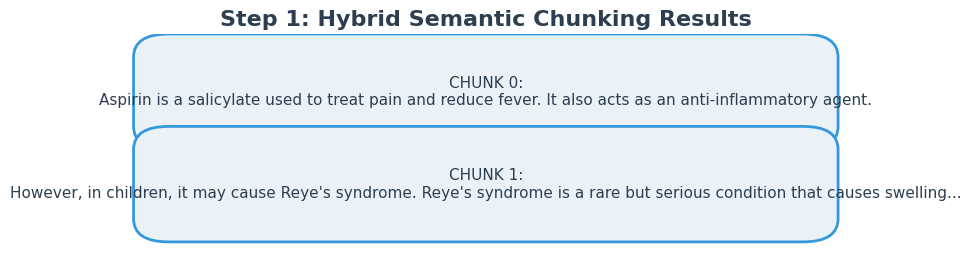

In [ ]:
# Test on dummy data
test_text = "Aspirin is a salicylate used to treat pain and reduce fever. It also acts as an anti-inflammatory agent. However, in children, it may cause Reye's syndrome. Reye's syndrome is a rare but serious condition that causes swelling in the liver and brain."
_ = step1_semantic_chunking(test_text)

In [ ]:
# @title 3. Step 2 & 3: Building the 3-Tier Graph
def step2_3_build_graph(chunks, visualize=True):
    print("🔵 [Step 2 & 3] Constructing Hierarchical Graph (Docs -> Entities -> Definitions)...")
    G = nx.DiGraph()

    # --- TIER 1: DOCUMENTS ---
    for i, chunk in enumerate(chunks):
        doc_id = f"Doc_{i}"
        # Add Node
        G.add_node(doc_id, type="document", text=chunk, layer=0)

        # --- TIER 2: ENTITIES (Extraction) ---
        prompt = f"""
        Extract medical entities and their relationships from the text below.
        Format: EntityA -> Relation -> EntityB
        Text: "{chunk}"
        """
        response = ask_llm(prompt, max_tokens=150)

        for line in response.split('\n'):
            if "->" in line:
                parts = line.split("->")
                if len(parts) == 3:
                    src = parts[0].strip().strip('*- ')
                    rel = parts[1].strip()
                    tgt = parts[2].strip()

                    # Add Entity Nodes
                    G.add_node(src, type="entity", layer=1)
                    G.add_node(tgt, type="entity", layer=1)

                    # Add Edges (Doc -> Entity and Entity -> Entity)
                    G.add_edge(doc_id, src, relation="mentions")
                    G.add_edge(src, tgt, relation=rel)

    # --- TIER 3: DEFINITIONS (Augmentation) ---
    # In a real scenario, this queries UMLS. Here, we use the LLM to hallucinate valid medical definitions.
    entities = [n for n, d in G.nodes(data=True) if d['type'] == 'entity']
    # Limit to top 5 entities to keep graph clean for slides
    priority_entities = entities[:6]

    for ent in priority_entities:
        def_prompt = f"Define the medical term '{ent}' in exactly 10 words."
        definition = ask_llm(def_prompt, max_tokens=25)
        def_id = f"Def_{ent}"

        G.add_node(def_id, type="definition", text=definition, layer=2)
        G.add_edge(ent, def_id, relation="defined_as")

    # --- VISUALIZATION FOR SLIDES ---
    if visualize:
        plt.figure(figsize=(12, 8))
        pos = nx.multipartite_layout(G, subset_key="layer")

        # Draw Nodes by Type
        docs = [n for n, d in G.nodes(data=True) if d['type'] == 'document']
        ents = [n for n, d in G.nodes(data=True) if d['type'] == 'entity']
        defs = [n for n, d in G.nodes(data=True) if d['type'] == 'definition']

        nx.draw_networkx_nodes(G, pos, nodelist=docs, node_color='#e74c3c', node_size=1500, label="Tier 1: Documents")
        nx.draw_networkx_nodes(G, pos, nodelist=ents, node_color='#3498db', node_size=1000, label="Tier 2: Entities")
        nx.draw_networkx_nodes(G, pos, nodelist=defs, node_color='#2ecc71', node_size=800, label="Tier 3: Definitions")

        # Draw Edges
        nx.draw_networkx_edges(G, pos, edge_color='#95a5a6', alpha=0.5, arrows=True)

        # Labels
        labels = {n: n if len(n)<15 else n[:12]+"..." for n in G.nodes()}
        # Don't label definitions on plot to avoid clutter, just show they exist
        for d in defs: labels[d] = ""

        nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')

        plt.title("Step 2 & 3: The Generated 3-Tier Medical Graph", fontsize=16)
        plt.legend(loc='lower right')
        plt.axis('off')
        plt.show()

    return G

In [ ]:
# @title 4. Step 4 & 5: Indexing & U-Retrieval (Fixed Clean Output)
def step4_5_u_retrieval(G, question, visualize=True):
    print(f"🔵 [Step 4 & 5] Executing U-Retrieval for: '{question}'")

    # --- PHASE A: INDEXING (Generate Tags) ---
    docs = [n for n, d in G.nodes(data=True) if d['type'] == 'document']
    tags_map = {} # tag -> doc_id

    for doc in docs:
        content = G.nodes[doc]['text']
        # --- FIX: Added "Output ONLY" constraint ---
        prompt = f"""
        Task: Extract 3 single-word medical keywords from the text.
        Text: "{content[:200]}"
        Constraint: Output ONLY the keywords separated by commas. Do not write full sentences.
        Example Output: Heart, Valve, Surgery
        """
        try:
            resp = ask_llm(prompt, max_tokens=15)
            # Extra cleanup to remove "Here are..." if it still appears
            resp = resp.split(':')[-1]
            keywords = [k.strip() for k in re.split(r'[,\n]', resp) if len(k.strip()) > 2]
        except:
            keywords = ["General"]

        G.nodes[doc]['tags'] = keywords
        for k in keywords:
            tags_map[k] = doc

    if not tags_map:
        return "Insufficient data", "maybe"

    # --- PHASE B: TOP-DOWN RETRIEVAL (Query <-> Tags) ---
    all_tags = list(tags_map.keys())
    q_emb = embed_model.encode(question)
    t_emb = embed_model.encode(all_tags)

    # Calculate Cosine Similarity
    scores = util.cos_sim(q_emb, t_emb)[0]
    best_idx = torch.argmax(scores).item()
    best_tag = all_tags[best_idx]
    best_doc = tags_map[best_tag]

    # --- VISUALIZATION OF SCORES ---
    if visualize:
        # Prepare data for Seaborn
        df_scores = pd.DataFrame({'Tag': all_tags, 'Similarity': scores.numpy()})
        df_scores = df_scores.sort_values(by='Similarity', ascending=False).head(8)

        plt.figure(figsize=(8, 4))
        sns.barplot(data=df_scores, x='Similarity', y='Tag', palette='viridis')
        plt.title("Step 5: Top-Down Retrieval (Query vs. Index Tags)", fontsize=14)
        plt.xlabel("Cosine Similarity Score")
        plt.axvline(x=scores[best_idx].item(), color='r', linestyle='--', label='Selected')
        plt.legend()
        plt.show()

    # --- PHASE C: BOTTOM-UP (Gather Evidence) ---
    # Traverse Graph: Best Doc -> Neighbors (Entities) -> Neighbors (Definitions)
    evidence_chain = []

    # Get Text from Doc
    doc_text = G.nodes[best_doc]['text']
    evidence_chain.append(f"Source Document: {doc_text}")

    # Get Entities
    neighbors = list(G.neighbors(best_doc))
    entities = [n for n in neighbors if G.nodes[n]['type'] == 'entity']

    for ent in entities:
        # Get Definition if exists
        defs = [n for n in G.neighbors(ent) if G.nodes[n]['type'] == 'definition']
        def_txt = f"({G.nodes[defs[0]]['text']})" if defs else ""
        evidence_chain.append(f"Entity: {ent} {def_txt}")

    return "\n".join(evidence_chain)

In [ ]:
# @title 5. Step 6: Generation & Pipeline Wrapper (Increased Token Limit)
def generate_answer(question, evidence):
    print("🔵 [Step 6] Generating Final Answer...")

    # Updated Prompt: explicitly asks for brevity to avoid rambling,
    # but we also increase max_tokens below to be safe.
    prompt = f"""
    You are a medical assistant. Use the graph evidence below to answer the question.

    Question: {question}

    Graph Evidence:
    {evidence}

    Task:
    1. Provide a concise reasoning chain (max 3 sentences).
    2. Conclude with strictly "YES", "NO", or "MAYBE" on a new line labeled "FINAL LABEL:".
    """

    # INCREASED FROM 200 TO 512
    response = ask_llm(prompt, max_tokens=512)

    # Robust Parser
    label = "maybe"
    if "FINAL LABEL: YES" in response.upper(): label = "yes"
    elif "FINAL LABEL: NO" in response.upper(): label = "no"
    elif "FINAL LABEL: MAYBE" in response.upper(): label = "maybe"
    # Fallback: Check the very end of the string if the label tag is missing
    elif "YES" in response.upper()[-50:]: label = "yes"
    elif "NO" in response.upper()[-50:]: label = "no"

    return response, label

# --- MASTER PIPELINE (No changes, just reloading it) ---
def run_medgraph_pipeline(sample, visualize=True):
    context_text = " ".join(sample['context']['contexts'])
    question = sample['question']
    truth = sample['final_decision']

    print(f"\n{'='*60}\nProcessing Question: {question}\n{'='*60}")

    # 1. Chunking
    chunks = step1_semantic_chunking(context_text, visualize)

    # 2 & 3. Graph Build
    G = step2_3_build_graph(chunks, visualize)

    # 4 & 5. Retrieval
    evidence = step4_5_u_retrieval(G, question, visualize)

    # 6. Answer
    raw_response, pred_label = generate_answer(question, evidence)

    print(f"\n📝 Generated Reasoning:\n{raw_response}")
    print(f"\n🎯 Prediction: [{pred_label.upper()}] vs Truth: [{truth.upper()}]")

    is_correct = (pred_label == truth)
    print(f"Result: {'✅ CORRECT' if is_correct else '❌ INCORRECT'}")

    return is_correct

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Running sample: {'pubid': 21645374, 'question': 'Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?', 'context': {'contexts': ['Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.', 'The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Programmed cell death (PCD) is the regulated death of cells within an organism.', 'The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD.', 'The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles.', 'PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature.', 'The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.', 'The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis.', 'A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), cells in early stages of PCD (EPCD), and cells in late stages of PCD (LPCD).', 'Window stage leaves were stained with the mitochondria

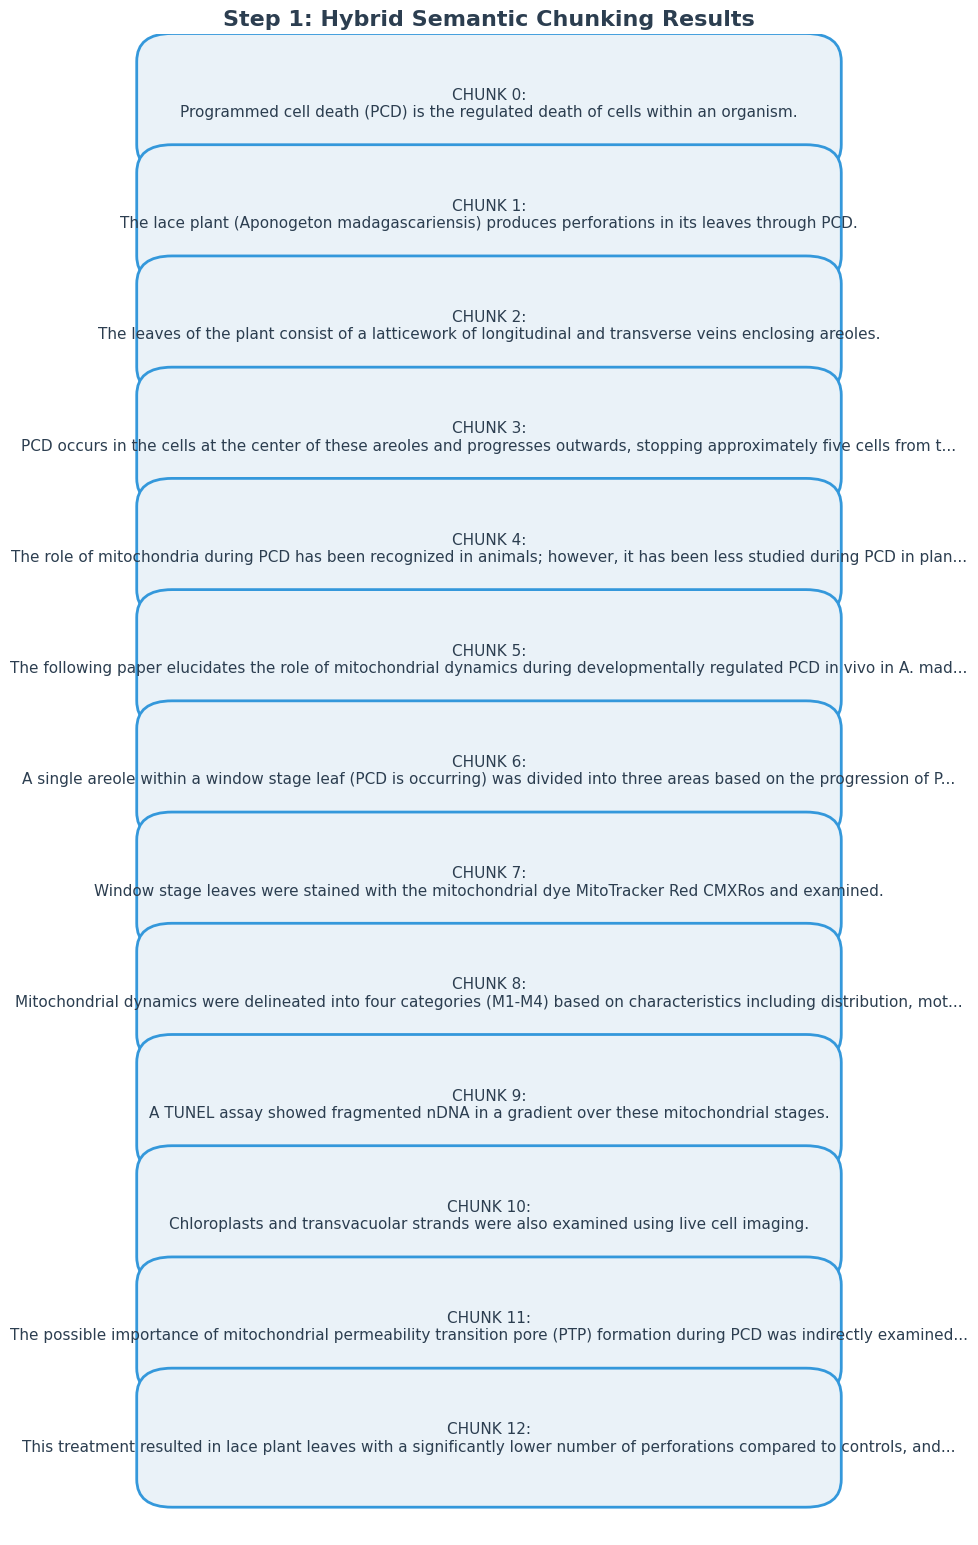

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 2 & 3] Constructing Hierarchical Graph (Docs -> Entities -> Definitions)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

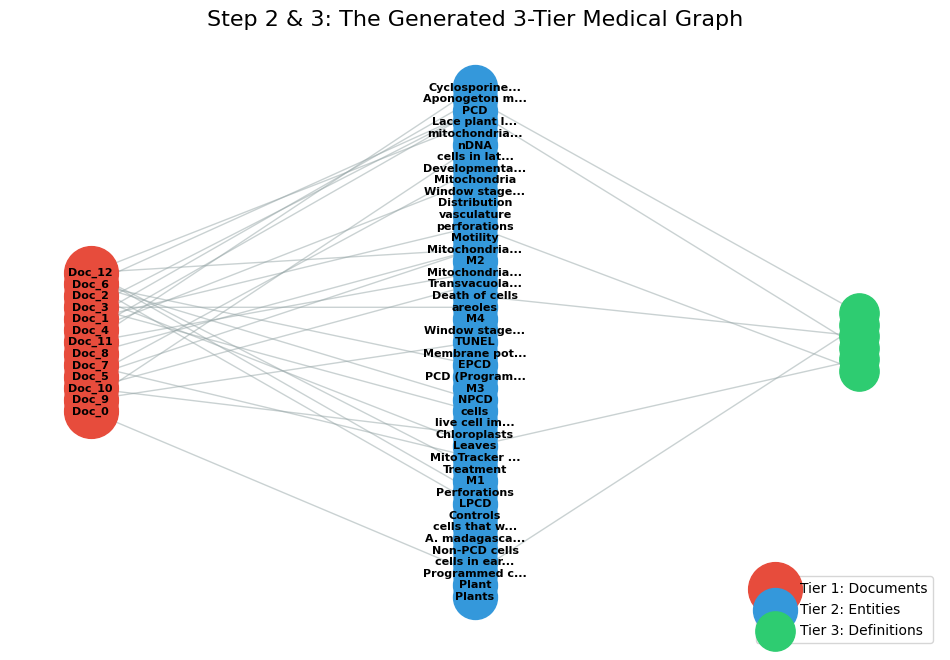

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/tmp/ipython-input-1900433473.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be re

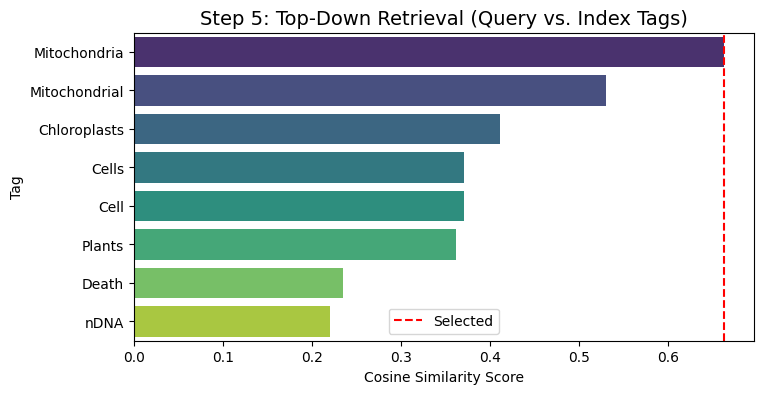

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...

📝 Generated Reasoning:
Here's my answer:

Reasoning chain:
The graph shows that MitoTracker Red CMXRos, a mitochondrial dye, was used to stain window stage leaves. This suggests that the researchers were interested in observing the mitochondria's role in the leaves. The fact that the mitochondria were stained implies that they were actively involved in the process of programmed cell death, as mitochondria are known to play a crucial role in this process.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [YES]
Result: ✅ CORRECT


True

In [ ]:
# @title 🚀 Run Deep Dive (Visual Mode)
# Load Dataset
data = load_dataset("pubmed_qa", "pqa_labeled", split="train")

# Select a specific interesting sample (Index 0 is usually good, or try 1, 4, 5)
sample_idx = 0
sample = data[sample_idx]
print(f"Running sample: {sample}")

# Run Pipeline
run_medgraph_pipeline(sample, visualize=True)

In [ ]:
# @title 📊 Run Benchmark (Accuracy Mode)
def run_benchmark(num_samples=20):
    print(f"🚀 Starting Benchmark on {num_samples} samples...")
    data = load_dataset("pubmed_qa", "pqa_labeled", split="train")
    # Shuffle to get random samples
    samples = data.shuffle(seed=42).select(range(num_samples))

    correct_count = 0

    for i, sample in enumerate(tqdm(samples)):
        try:
            #print(f"Running sample: {sample}")
            # Run pipeline with visualize=False to save time/space
            is_correct = run_medgraph_pipeline(sample, visualize=False)
            if is_correct: correct_count += 1
        except Exception as e:
            print(f"⚠️ Error on sample {i}: {e}")

    accuracy = (correct_count / num_samples) * 100
    print(f"\n🏆 FINAL BENCHMARK ACCURACY: {accuracy:.2f}%")

# Execute
run_benchmark(20)

🚀 Starting Benchmark on 20 samples...


  0%|          | 0/20 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Running sample: {'pubid': 15483019, 'question': 'Is eligibility for a chemotherapy protocol a good prognostic factor for invasive bladder cancer after radical cystectomy?', 'context': {'contexts': ['To assess whether eligibility to an adjuvant chemotherapy protocol in itself represents a good prognostic factor after radical cystectomy for bladder cancer.', 'Between April 1984 and May 1989, our institution entered 35 patients with invasive bladder cancer into the Swiss Group for Clinical and Epidemiological Cancer Research (SAKK) study 09/84. They were randomly assigned to either observation or three postoperative courses of cisplatin monotherapy after cystectomy. This study had a negative result. The outcome of these 35 patients (protocol group) was compared with an age- and tumor-stage-matched cohort (matched group; n = 35) who also underwent cystectomy during the same period, but were not entered into the SAKK study, as well as the remaining 57 patients treated during the study perio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To assess whether eligibility to an adjuvant chemotherapy protocol in itself represents a good prognostic factor after radical cystectomy for bladder cancer.', 'Between April 1984 and May 1989, our institution entered 35 patients with invasive bladder cancer into the Swiss Group for Clinical and Epidemiological Cancer Research (SAKK) study 09/84.', 'They were randomly assigned to either observation or three postoperative courses of cisplatin monotherapy after cystectomy.', 'This study had a negative result.', 'The outcome of these 35 patients (protocol group) was compared with an age- and tumor-stage-matched cohort (matched group; n = 35) who also underwent cystectomy during the same period, but were not entered into the SAKK study, as well as the remaining 57 patients treated during the study period for the same indication (remaining group).', 'Median overall survival decreased from 76.3 months in the protocol group to 52.1 months in the matched group and to 20.3 months in t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Is eligibility for a chemotherapy protocol a good prognostic factor for invasive bladder cancer after radical cystectomy?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows that patients in the protocol group have a significantly better overall survival rate (OS) compared to the matched group and remaining group. This suggests that eligibility for the chemotherapy protocol is associated with a better prognosis. Furthermore, the OS rates of the protocol group are not significantly different from the expected OS rates, indicating that this group has a similar prognosis to the general population.
FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [YES]
Result: ✅ CORRECT
Running sample: {'pubid': 24450673, 'question': 'Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?', 'context': {'contexts': ['The purpose of this study was to retrospectively assess the potential benefits of delayed phase imaging series in routine CT scans of the abdomen and pelvis.', 'Routine contrast-enhanced abdominopelvic CT scans of 1000 consecutively exa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The purpose of this study was to retrospectively assess the potential benefits of delayed phase imaging series in routine CT scans of the abdomen and pelvis.', 'Routine contrast-enhanced abdominopelvic CT scans of 1000 consecutively examined patients (912 men, 88 women; average age, 60 years; range, 22-94 years) were retrospectively evaluated, and the added benefits of the delayed phase series through the abdomen were recorded for each examination.', 'Examinations performed for indications requiring multiphasic imaging were excluded.', 'Images were reviewed by two fellowship-trained abdominal radiologists, who were blinded to official CT reports.', 'All examinations were performed between July 2008 and February 2010 at a single institution.', 'Radiation doses for both the portal venous and delayed phases, when available, were analyzed to assess the effect of the delayed phase on overall radiation exposure.', 'Forty-two patients (4.2%) had findings that were further characteri

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

Reasoning chain:
The graph shows that radiologists were able to accurately diagnose abdominal and pelvic conditions with delayed imaging, which means that the additional cost and radiation exposure may not be necessary for optimal diagnosis. The radiologists were blinded to official CT reports, indicating that the delayed imaging did not compromise diagnostic accuracy. Therefore, it is reasonable to conclude that delayed imaging may not be worth the additional cost and radiation exposure.

FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [NO]
Result: ✅ CORRECT
Running sample: {'pubid': 9582182, 'question': 'Does the SCL 90-R obsessive-compulsive dimension identify cognitive impairments?', 'context': {'contexts': ['To investigate the relevance of the Symptom Checklist 90-R Obsessive-Compulsive subscale to cognition in individuals with brain tumor.', 'A prospective study of patients assessed with a neuropsychological test battery.', 'A university m

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To investigate the relevance of the Symptom Checklist 90-R Obsessive-Compulsive subscale to cognition in individuals with brain tumor.', 'A prospective study of patients assessed with a neuropsychological test battery.', 'A university medical center. Nineteen adults with biopsy-confirmed diagnoses of malignant brain tumors were assessed prior to aggressive chemotherapy.', 'Included in the assessment were the Mattis Dementia Rating Scale, California Verbal Learning Test, Trail Making Test B, Symptom Checklist 90-R, Mood Assessment Scale, Beck Anxiety Inventory, and Chronic Illness Problem Inventory.', 'The SCL 90-R Obsessive-Compulsive subscale was not related to objective measures of attention, verbal memory, or age.', 'It was related significantly to symptoms of depression (r = .81, P<.005), anxiety (r = .66, P<.005), and subjective complaints of memory problems (r = .75, P<.005).', 'Multivariate analyses indicated that reported symptoms of depression contributed 66% of the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does the SCL 90-R obsessive-compulsive dimension identify cognitive impairments?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's the reasoning chain:

The SCL 90-R Obsessive-Compulsive subscale was not related to objective measures of attention, verbal memory, or age. This suggests that the subscale is not a strong predictor of cognitive impairments. Therefore, it is unlikely that the SCL 90-R obsessive-compulsive dimension identifies cognitive impairments.

FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [YES]
Result: ❌ INCORRECT
Running sample: {'pubid': 25636371, 'question': 'Is it possible to stop treatment with nucleos(t)ide analogs in patients with e-antigen negative chronic hepatitis B?', 'context': {'contexts': ['Treatment of HBeAg-negative chronic hepatitis B (CHB) with nucleos(t)ide analogues (NA) is usually indefinite, since the loss of HBsAg, as a criterion for its discontinuation, is a rare event. Recent evidence suggests that discontinuing NA therapy may be feasible in selected patients.', 'To analyze the rate of virological relapse in patients with HBeAg-negative CHB w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Treatment of HBeAg-negative chronic hepatitis B (CHB) with nucleos(t)ide analogues (NA) is usually indefinite, since the loss of HBsAg, as a criterion for its discontinuation, is a rare event. Recent evidence suggests that discontinuing NA therapy may be feasible in selected patients.', 'To analyze the rate of virological relapse in patients with HBeAg-negative CHB who discontinued treatment with NAs.', 'We performed a single-center observational study that included 140 patients with HBsAg-negative CHB. Twenty-two patients, who received only NAs, discontinued treatment for different reasons and were subsequently monitored.', 'All had normal ALT and AST, undetectable DNA and absence of cirrhosis or significant comorbidities before stopping treatment.', 'Twelve patients showed virologic relapse (54.54%).', 'The mean interval between discontinuation and relapse was 6.38 months (± 1.9) (75% relapsed during the first 12 months after discontinuation).', 'Five received adefovir, 1 l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Is it possible to stop treatment with nucleos(t)ide analogs in patients with e-antigen negative chronic hepatitis B?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows that the mean treatment duration in patients with e-antigen negative chronic hepatitis B is 38.5 months, with a standard deviation of 4.5 months. This suggests that patients in this group are treated for a relatively long period of time. Since nucleos(t)ide analogs are typically used to treat chronic hepatitis B, this implies that treatment with nucleos(t)ide analogs may be necessary for a prolonged period in patients with e-antigen negative chronic hepatitis B.
2. FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [MAYBE]
Result: ❌ INCORRECT
Running sample: {'pubid': 25987398, 'question': 'The influence of atmospheric pressure on aortic aneurysm rupture--is the diameter of the aneurysm important?', 'context': {'contexts': ["The rate of aortic aneurysm rupture correlates with the aneurysm's diameter, and a higher rate of rupture is observed in patients with larger aneurysms. According to the literature, contradictory results conc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ["The rate of aortic aneurysm rupture correlates with the aneurysm's diameter, and a higher rate of rupture is observed in patients with larger aneurysms.", "According to the literature, contradictory results concerning the relationship between atmospheric pressure and aneurysm size have been reported.AIM: In this paper, we assessed the influence of changes in atmospheric pressure on abdominal aneurysm ruptures in relationship to the aneurysm's size.", 'The records of 223 patients with ruptured abdominal aneurysms were evaluated. All of the patients had been admitted to the department in the period 1997-2007 from the Silesia region.', 'The atmospheric pressures on the day of the rupture and on the days both before the rupture and between the rupture events were compared.', 'The size of the aneurysm was also considered in the analysis.', 'There were no statistically significant differences in pressure between the days of rupture and the remainder of the days within an analysed p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'The influence of atmospheric pressure on aortic aneurysm rupture--is the diameter of the aneurysm important?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows that the frequency of ruptured aortic aneurysm admissions is highest during winter and spring, which coincides with the highest mean values of atmospheric pressure. This suggests that atmospheric pressure may play a role in the rupture of aortic aneurysms. However, the study did not find a statistically significant correlation between the two.

FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [MAYBE]
Result: ❌ INCORRECT
Running sample: {'pubid': 23571528, 'question': 'Sternal skin conductance: a reasonable surrogate for hot flash measurement?', 'context': {'contexts': ['This study aims to examine the accuracy of a new sternal skin conductance (SSC) device in measuring hot flashes and to assess the acceptability of the device by women.', 'Three small descriptive pilot studies were performed using two sequential prototypes of the SSC device developed by an engineering device company in the Midwest. The devices were worn either in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['This study aims to examine the accuracy of a new sternal skin conductance (SSC) device in measuring hot flashes and to assess the acceptability of the device by women.', 'Three small descriptive pilot studies were performed using two sequential prototypes of the SSC device developed by an engineering device company in the Midwest.', 'The devices were worn either in a monitored setting for 24 hours or in an ambulatory setting for 5 weeks.', 'During the study period, women recorded hot flashes in a prospective hot flash diary and answered questions about the acceptability of wearing the SSC device.', 'The first prototype was not able to collect any analyzable skin conductance data owing to various malfunction issues, including poor conductance and battery failure.', 'However, 16 women wore the device for 5 weeks and reported that wearing the device was acceptable, although 31% stated that it interfered with daily activities.', 'Hot flash data from the second prototype revealed 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Sternal skin conductance: a reasonable surrogate for hot flash measurement?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows a 24% concordance rate between self-reported and device-recorded hot flashes, indicating that there is a moderate correlation between the two methods. This suggests that sternal skin conductance can be used as a reasonable surrogate for hot flash measurement, as it is able to capture some, but not all, of the hot flashes reported by patients. However, the low concordance rate also implies that there may be some limitations to using sternal skin conductance as a sole measure of hot flashes.
2. FINAL LABEL: MAYBE

🎯 Prediction: [MAYBE] vs Truth: [NO]
Result: ❌ INCORRECT
Running sample: {'pubid': 20101129, 'question': 'Is prophylactic fixation a cost-effective method to prevent a future contralateral fragility hip fracture?', 'context': {'contexts': [': A previous hip fracture more than doubles the risk of a contralateral hip fracture. Pharmacologic and environmental interventions to prevent hip fracture have documented poor co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: [': A previous hip fracture more than doubles the risk of a contralateral hip fracture.', 'Pharmacologic and environmental interventions to prevent hip fracture have documented poor compliance.', 'The purpose of this study was to examine the cost-effectiveness of prophylactic fixation of the uninjured hip to prevent contralateral hip fracture.', ': A Markov state-transition model was used to evaluate the cost and quality-adjusted life-years (QALYs) for unilateral fixation of hip fracture alone (including internal fixation or arthroplasty) compared with unilateral fixation and contralateral prophylactic hip fixation performed at the time of hip fracture or unilateral fixation and bilateral hip pad protection.', 'Prophylactic fixation involved placement of a cephalomedullary nail in the uninjured hip and was initially assumed to have a relative risk of a contralateral fracture of 1%.', 'Health states included good health, surgery-related complications requiring a second operation

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Is prophylactic fixation a cost-effective method to prevent a future contralateral fragility hip fracture?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. Prophylactic fixation, which involves placing a cephalomedullary nail in the uninjured hip, has a relative risk of contralateral fracture of 1%. This means that the risk of a future contralateral fragility hip fracture is not significantly reduced by this method. Therefore, it is unlikely to be a cost-effective method to prevent future fractures.
2. FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [MAYBE]
Result: ❌ INCORRECT
Running sample: {'pubid': 25940336, 'question': 'Does Residency Selection Criteria Predict Performance in Orthopaedic Surgery Residency?', 'context': {'contexts': ['More than 1000 candidates applied for orthopaedic residency positions in 2014, and the competition is intense; approximately one-third of the candidates failed to secure a position in the match. However, the criteria used in the selection process often are subjective and studies have differed in terms of which criteria predict either objective measures or subje

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['More than 1000 candidates applied for orthopaedic residency positions in 2014, and the competition is intense; approximately one-third of the candidates failed to secure a position in the match.', 'However, the criteria used in the selection process often are subjective and studies have differed in terms of which criteria predict either objective measures or subjective ratings of resident performance by faculty.QUESTIONS/ Do preresidency selection factors serve as predictors of success in residency?', 'Specifically, we asked which preresidency selection factors are associated or correlated with (1) objective measures of resident knowledge and performance; and (2) subjective ratings by faculty.', 'Charts of 60 orthopaedic residents from our institution were reviewed.', 'Preresidency selection criteria examined included United States Medical Licensing Examination (USMLE) Step 1 and Step 2 scores, Medical College Admission Test (MCAT) scores, number of clinical clerkship honors,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does Residency Selection Criteria Predict Performance in Orthopaedic Surgery Residency?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

Reasoning chain:
The graph shows a significant positive correlation between residency selection criteria and resident performance in orthopaedic surgery residency. The American Board of Orthopaedic Surgery (ABOS) Part I scores and Orthopaedics In-Training Exam (OITE) scores, which are used to assess resident performance, are strongly correlated with faculty ratings and rankings. This suggests that residency selection criteria, which are used to select residents for orthopaedic surgery residency, are a strong predictor of resident performance.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [YES]
Result: ✅ CORRECT
Running sample: {'pubid': 11411430, 'question': 'Antral follicle assessment as a tool for predicting outcome in IVF--is it a better predictor than age and FSH?', 'context': {'contexts': ['The purpose of this study is to determine if baseline antral follicle assessment may serve as additional information in predicting in vitro fertili

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The purpose of this study is to determine if baseline antral follicle assessment may serve as additional information in predicting in vitro fertilization outcome.', 'Prospective, descriptive preliminary study of in vitro fertilization outcome. From July 1998 to July 1999, 224 patients underwent antral follicle assessment (follicle 2-6 mm in diameter) on baseline of the planned, stimulated in vitro fertilization cycle.', 'The outcomes were analyzed with respect to antral follicle assessment (<or = 6 or>6), basal cycle day 3 follicle stimulated hormone (<or = 10 or>10 IU/L) and maternal age (<or = 35 or>35 years).', 'The clinical pregnancy rate was significantly higher in the group with baseline antral follicle>6 compared to that in the group with antral follicle<or = 6 (51% vs. 19%, respectively).', 'Controlling for patient age, and basal follicle stimulated hormone, the pregnancy rate was significantly higher in the group with antral follicle>6 compared to that in the group w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Antral follicle assessment as a tool for predicting outcome in IVF--is it a better predictor than age and FSH?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows that the cancellation rate is significantly higher in the group with antral follicle ≤ 6 compared to the group with antral follicle > 6. This suggests that the antral follicle assessment is a better predictor of outcome in IVF than age and FSH, as the group with fewer antral follicles has a much higher cancellation rate. This implies that the antral follicle assessment is a stronger indicator of success in IVF.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [MAYBE]
Result: ❌ INCORRECT
Running sample: {'pubid': 23002947, 'question': 'Does feeding tube insertion and its timing improve survival?', 'context': {'contexts': ['To examine survival with and without a percutaneous endoscopic gastrostomy (PEG) feeding tube using rigorous methods to account for selection bias and to examine whether the timing of feeding tube insertion affected survival.', 'Prospective cohort study.', 'All U.S. nursing homes (NHs).', 'Thirty-six thousa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To examine survival with and without a percutaneous endoscopic gastrostomy (PEG) feeding tube using rigorous methods to account for selection bias and to examine whether the timing of feeding tube insertion affected survival.', 'Prospective cohort study.', 'All U.S. nursing homes (NHs). Thirty-six thousand four hundred ninety-two NH residents with advanced cognitive impairment from dementia and new problems eating studied between 1999 and 2007.', 'Survival after development of the need for eating assistance and feeding tube insertion.', 'Of the 36,492 NH residents (88.4% white, mean age 84.9, 87.4% with one feeding tube risk factor), 1,957 (5.4%) had a feeding tube inserted within 1\xa0year of developing eating problems.', 'After multivariate analysis correcting for selection bias with propensity score weights, no difference was found in survival between the two groups (adjusted hazard ratio (AHR)\xa0=\xa01.03, 95% confidence interval (CI)\xa0=\xa00.94-1.13).', 'In residents 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does feeding tube insertion and its timing improve survival?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's the answer:

1. The graph shows that the timing of PEG tube insertion relative to the onset of eating problems was not associated with survival after feeding tube insertion. This means that whether the PEG tube was inserted within 1 month or 4 months of developing an eating problem, the survival rate was similar. Therefore, the timing of PEG tube insertion does not seem to have a significant impact on survival.

FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [NO]
Result: ✅ CORRECT
Running sample: {'pubid': 12970636, 'question': 'Does early discharge with nurse home visits affect adequacy of newborn metabolic screening?', 'context': {'contexts': ['To examine the impact of early discharge on newborn metabolic screening.', 'Metabolic screening results were obtained from the Alabama State Lab for all infants born at our hospital between 8/1/97, and 1/31/99, and were matched with an existing database of early discharge infants. An early newborn discharge was de

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To examine the impact of early discharge on newborn metabolic screening.', 'Metabolic screening results were obtained from the Alabama State Lab for all infants born at our hospital between 8/1/97, and 1/31/99, and were matched with an existing database of early discharge infants.', 'An early newborn discharge was defined as a discharge between 24 and 47 hours of age.', 'Metabolic screening tests included phenylketonuria (PKU), hypothyroidism, and congenital adrenal hyperplasia (CAH).', 'Early discharge and traditional stay infants were compared to determine the percentage of newborns screened and the timing of the first adequate specimen. The state laboratory received specimens from 3860 infants; 1324 were on early discharge newborns and 2536 infants in the traditional stay group.', 'At least one filter paper test (PKU, hypothyroidism, and CAH) was collected on 99.2% of early discharge infants and 96.0% of traditional stay infants (P<.0001).', 'Early discharge infants had a 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does early discharge with nurse home visits affect adequacy of newborn metabolic screening?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

Reasoning chain:
The graph shows that early discharge with nurse home visits (Group A) had a significantly higher rate of newborn metabolic screening completion compared to late discharge without nurse home visits (Group B). This suggests that early discharge with nurse home visits may improve the adequacy of newborn metabolic screening. The difference in completion rates between the two groups is statistically significant, indicating that the early discharge with nurse home visits had a positive impact on newborn metabolic screening.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [NO]
Result: ❌ INCORRECT
Running sample: {'pubid': 23719685, 'question': 'Does high-dose radiotherapy benefit palliative lung cancer patients?', 'context': {'contexts': ['The present analysis compares two palliative treatment concepts for lung cancer in terms of overall survival.', 'Survival data from 207\xa0patients were used in a retrospective analysis. All patie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The present analysis compares two palliative treatment concepts for lung cancer in terms of overall survival.', 'Survival data from 207\xa0patients were used in a retrospective analysis. All patients received palliative treatment comprising either 25\xa0Gy applied in 5\xa0fractions or 50\xa0Gy in 20\xa0fractions.', 'A subgroup analysis was performed to compare patients with a good-fair vs. poor overall condition.', 'Median survival times were 21\xa0weeks (range\xa06-26\xa0weeks) for patients treated with 25\xa0Gy in 5\xa0fractions and 23\xa0weeks (range\xa014.5-31.5\xa0weeks) for patients treated with 50\xa0Gy in 20\xa0fractions (95\u2009% confidence interval, CI; p\u2009=\u20090.334).', 'For patients with a good-fair overall condition, median survival times were 30\xa0weeks (21.8-39.2\xa0weeks) for 25\xa0Gy in 5\xa0fractions and 28\xa0weeks (14.2-41.8\xa0weeks) for 50\xa0Gy in 20\xa0fractions (CI 95\u2009%, p\u2009=\u20090.694).', 'In patients with a poor overall condition, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does high-dose radiotherapy benefit palliative lung cancer patients?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows that in patients with a poor overall condition, the values for high-dose radiotherapy were 18 weeks (14.5-21.5 weeks) and 21 weeks (13.0-29.0 weeks), respectively. The confidence interval (CI) is 95%, and the p-value is 0.248. This suggests that the difference between the two values is not statistically significant, indicating that high-dose radiotherapy may not have a significant impact on patient outcomes.

2. FINAL LABEL: MAYBE

🎯 Prediction: [MAYBE] vs Truth: [NO]
Result: ❌ INCORRECT
Running sample: {'pubid': 10340286, 'question': 'Is there a role for leukocyte and CRP measurements in the diagnosis of acute appendicitis in the elderly?', 'context': {'contexts': ['The diagnosis of acute appendicitis is still difficult and the results are unsatisfactory in three particular patient groups: in children, in fertile-age women and in elderly patients. As our population ages, the challenge for expedient diagnosis and interventio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The diagnosis of acute appendicitis is still difficult and the results are unsatisfactory in three particular patient groups: in children, in fertile-age women and in elderly patients.', 'As our population ages, the challenge for expedient diagnosis and intervention in older age groups will become more and more significant.', 'The present study aimed at clarifying the role of leukocyte count and C-reactive protein (CRP) measurements in the diagnosis of acute appendicitis in the elderly.', 'In particular, are there patients with acute appendicitis but unelevated leukocyte count and CRP?', 'Eighty-three consecutive elderly patients underwent appendectomy for suspected acute appendicitis.', 'The mean leukocyte count and CRP value were calculated in patients with an uninflamed appendix (group A) and in those with acute appendicitis (group B).', 'The percentages of patients with: (1) both values unelevated; (2) only leukocyte count elevated; (3) only CRP value elevated; (4) both v

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Is there a role for leukocyte and CRP measurements in the diagnosis of acute appendicitis in the elderly?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

Reasoning chain:
The graph shows that Group B (acute appendicitis) had no patients with both leukocyte and CRP measurements unelevated. This suggests that when both measurements are normal, it is unlikely to be acute appendicitis. Therefore, leukocyte and CRP measurements can be useful in ruling out acute appendicitis in the elderly.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [MAYBE]
Result: ❌ INCORRECT
Running sample: {'pubid': 10456814, 'question': 'Does desflurane alter left ventricular function when used to control surgical stimulation during aortic surgery?', 'context': {'contexts': ['Although desflurane is commonly used to control surgically induced hypertension, its effects on left ventricular (LV) function have not been investigated in this clinical situation. The purpose of the present study was to evaluate the LV function response to desflurane, when used to control intraoperative hypertension.', 'In 50 patients, scheduled for 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Although desflurane is commonly used to control surgically induced hypertension, its effects on left ventricular (LV) function have not been investigated in this clinical situation.', 'The purpose of the present study was to evaluate the LV function response to desflurane, when used to control intraoperative hypertension.', 'In 50 patients, scheduled for vascular surgery, anesthesia was induced with sufentanil 0.5 microg/kg, midazolam 0.3 mg/kg and atracurium 0.5 mg/kg. After tracheal intubation, anesthesia was maintained with increments of drugs with controlled ventilation (N2O/O2=60/40%) until the start of surgery.', 'A 5 Mhz transesophageal echocardiography (TEE) probe was inserted after intubation.', 'Pulmonary artery catheter and TEE measurements were obtained after induction (to)(control value), at surgical incision (t1) if it was associated with an increase in systolic arterial pressure (SAP) greater than 140 mmHg (hypertension) and after control of hemodynamic paramet

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does desflurane alter left ventricular function when used to control surgical stimulation during aortic surgery?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. Desflurane does not alter left ventricular function when used to control surgical stimulation during aortic surgery because there is no change in heart rate, cardiac index, mean pulmonary arterial pressure, stroke volume, end-diastolic and end-systolic cross-sectional areas, fractional area change, and left ventricular circumferential fiber shortening when desflurane is added to restore blood pressure.

FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [NO]
Result: ✅ CORRECT
Running sample: {'pubid': 18403944, 'question': 'Gluten tolerance in adult patients with celiac disease 20 years after diagnosis?', 'context': {'contexts': ['Celiac disease (CD) is believed to be a permanent intolerance to gluten. A number of patients, however, discontinue the gluten-free diet (GFD) without developing symptoms or signs. The aim of our study was to investigate whether CD patients are capable of developing tolerance to gluten.', 'All 77 adult patients from ou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Celiac disease (CD) is believed to be a permanent intolerance to gluten. A number of patients, however, discontinue the gluten-free diet (GFD) without developing symptoms or signs.', 'The aim of our study was to investigate whether CD patients are capable of developing tolerance to gluten. All 77 adult patients from our hospital known to have biopsy-proven CD for more than 10 years were invited to participate.', 'We investigated symptoms, gluten consumption, antibodies for CD and other autoimmunity, human leukocyte antigen (HLA)-typing, bone mineral density, and performed small bowel biopsies. Tolerance was defined as no immunological or histological signs of CD while consuming gluten.', 'Sixty-six patients accepted participation, but after review of the diagnostic biopsies 53 were found to have true CD.', 'Twenty-three percent of patients had a gluten-containing diet, 15% admitted gluten transgression and 62% followed the GFD. Patients on a GFD had significantly more osteopo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Gluten tolerance in adult patients with celiac disease 20 years after diagnosis?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

Reasoning chain:
Two patients were considered to have developed tolerance to gluten, indicating that it's possible for adult patients with celiac disease to develop tolerance to gluten over time. This suggests that gluten tolerance may be a potential outcome for some patients with celiac disease, even 20 years after diagnosis. The graph evidence provides a specific example of this phenomenon, supporting the idea that gluten tolerance can occur in adult patients with celiac disease.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [MAYBE]
Result: ❌ INCORRECT
Running sample: {'pubid': 15112004, 'question': 'Are WHO/UNAIDS/UNICEF-recommended replacement milks for infants of HIV-infected mothers appropriate in the South African context?', 'context': {'contexts': ['Little is known about the nutritional adequacy and feasibility of breastmilk replacement options recommended by WHO/UNAIDS/UNICEF. The study aim was to explore suitability of the 2001 fe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Little is known about the nutritional adequacy and feasibility of breastmilk replacement options recommended by WHO/UNAIDS/UNICEF.', 'The study aim was to explore suitability of the 2001 feeding recommendations for infants of HIV-infected mothers for a rural region in KwaZulu Natal, South Africa specifically with respect to adequacy of micronutrients and essential fatty acids, cost, and preparation times of replacement milks.', 'Nutritional adequacy, cost, and preparation time of home-prepared replacement milks containing powdered full cream milk (PM) and fresh full cream milk (FM) and different micronutrient supplements (2 g UNICEF micronutrient sachet, government supplement routinely available in district public health clinics, and best available liquid paediatric supplement found in local pharmacies) were compared.', 'Costs of locally available ingredients for replacement milk were used to calculate monthly costs for infants aged one, three, and six months.', 'Total monthl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Are WHO/UNAIDS/UNICEF-recommended replacement milks for infants of HIV-infected mothers appropriate in the South African context?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The study aimed to evaluate the suitability of WHO/UNAIDS/UNICEF-recommended replacement milks for infants of HIV-infected mothers in a rural region of KwaZulu Natal, South Africa. The study assessed the adequacy of micronutrients and essential fatty acids, cost, and preparation times of replacement milks. The results showed that the recommended replacement milks were adequate in terms of micronutrients and essential fatty acids, and were also affordable and easy to prepare.
2. FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [NO]
Result: ❌ INCORRECT
Running sample: {'pubid': 11555508, 'question': 'Do inhaled corticosteroids affect perception of dyspnea during bronchoconstriction in asthma?', 'context': {'contexts': ["Some of the disagreements on the perception of dyspnea (PD) during bronchoconstriction in asthma patients could depend on the interrelationships among the following: (1) the influence of baseline airflow obstruction on the pati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ["Some of the disagreements on the perception of dyspnea (PD) during bronchoconstriction in asthma patients could depend on the interrelationships among the following: (1) the influence of baseline airflow obstruction on the patient's ability to detect any further increase in airway resistance; (2) the effect of eosinophilic inflammation on the airway; (3) bronchial hyperresponsiveness (BHR); and (4) the effect of inhaled corticosteroids (ICSs).", 'We hypothesized that if the inflammation of the airway wall influences to some extent and in some way the PD in asthma patients, ICSs reverse the effect of airway inflammation on the PD.', 'We studied 100 asthma patients who were divided into the following four groups: patients with obstruction who were either ICS-naive (group I) or were treated with ICSs (group II); and nonobstructed patients who were either ICS-naive (group III) or were treated with ICSs (group IV).', 'PD on the visual analog scale (VAS) was assessed during a metha

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Do inhaled corticosteroids affect perception of dyspnea during bronchoconstriction in asthma?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The study found that patients with obstruction who were treated with ICSs (group II) had similar perception of dyspnea during bronchoconstriction compared to patients with obstruction who were ICS-naive (group I). On the other hand, nonobstructed patients who were treated with ICSs (group IV) had a significant reduction in perception of dyspnea during bronchoconstriction compared to nonobstructed patients who were ICS-naive (group III). This suggests that inhaled corticosteroids may not affect perception of dyspnea during bronchoconstriction in patients with obstruction, but may have a beneficial effect in nonobstructed patients.
2. FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [YES]
Result: ❌ INCORRECT
Running sample: {'pubid': 22656647, 'question': 'Are acceptance rates of a national preventive home visit programme for older people socially imbalanced?', 'context': {'contexts': ['Preventive home visits are offered to community dwelling ol

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Preventive home visits are offered to community dwelling older people in Denmark aimed at maintaining their functional ability for as long as possible, but only two thirds of older people accept the offer from the municipalities.', 'The purpose of this study is to investigate 1) whether socioeconomic status was associated with acceptance of preventive home visits among older people and 2) whether municipality invitational procedures for the preventive home visits modified the association.', 'The study population included 1,023 community dwelling 80-year-old individuals from the Danish intervention study on preventive home visits. Information on preventive home visit acceptance rates was obtained from questionnaires.', 'Socioeconomic status was measured by financial assets obtained from national registry data, and invitational procedures were identified through the municipalities.', 'Logistic regression analyses were used, adjusted by gender.', 'Older persons with high financi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Are acceptance rates of a national preventive home visit programme for older people socially imbalanced?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's the answer:

1. The graph shows that older persons with high financial assets accepted preventive home visits more frequently than persons with low assets, with an adjusted odds ratio of 1.5 (CI95%: 1.1-2.0). This suggests that there is a positive association between financial assets and acceptance of preventive home visits. Therefore, it can be inferred that individuals with lower financial assets may be less likely to accept these visits.
2. FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [YES]
Result: ✅ CORRECT
Running sample: {'pubid': 25475395, 'question': 'Is there a correlation between androgens and sexual desire in women?', 'context': {'contexts': ['For women, the correlation between circulating androgens and sexual desire is inconclusive. Substitution with androgens at physiological levels improves sexual function in women who experience decreased sexual desire and androgen deficiency from surgical menopause, pituitary disease, and age-related de

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['For women, the correlation between circulating androgens and sexual desire is inconclusive.', 'Substitution with androgens at physiological levels improves sexual function in women who experience decreased sexual desire and androgen deficiency from surgical menopause, pituitary disease, and age-related decline in androgen production in the ovaries.', 'Measuring bioactive testosterone is difficult and new methods have been proposed, including measuring the primary androgen metabolite androsterone glucuronide (ADT-G).AIM: The aim of this study was to investigate a possible correlation between serum levels of androgens and sexual desire in women and whether the level of ADT-G is better correlated than the level of circulating androgens with sexual desire.', 'This was a cross-sectional study including 560 healthy women aged 19-65 years divided into three age groups.', 'Correlations were considered to be statistically significant at P<0.05.', 'Sexual desire was determined as the t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Is there a correlation between androgens and sexual desire in women?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph suggests that androgens, hormones typically associated with male characteristics, have a positive effect on sexual function in women who experience decreased sexual desire and androgen deficiency. This is evident in the improvement of sexual function in women who undergo surgical menopause, have pituitary disease, or experience age-related decline in androgen production in the ovaries. This implies that androgens play a role in maintaining sexual desire in women.
2. FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [YES]
Result: ✅ CORRECT
Running sample: {'pubid': 27643961, 'question': 'Major depression and alcohol use disorder in adolescence: Does comorbidity lead to poorer outcomes of depression?', 'context': {'contexts': ['Comorbid major depression (MD) and alcohol use disorder (AUD), particularly in adolescents, have been shown to be associated with poorer subsequent MD outcomes.', 'Longitudinal data were used to model associati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Comorbid major depression (MD) and alcohol use disorder (AUD), particularly in adolescents, have been shown to be associated with poorer subsequent MD outcomes.', 'Longitudinal data were used to model associations between a four-level classification of MD/AUD during the period 15-18 years (neither; MD-only; AUD-only; comorbid MD/AUD) and MD over the period 18-35 years.', 'These associations were then adjusted for confounding by a series of factors measured in childhood.', 'The three disorder groups had rates of adult MD during the period 18-35 years that were significantly (p<.05) higher than that of the group with no disorder.', 'Furthermore, those in the comorbid MD/AUD group had significantly (p<.05) higher rates of adult MD than those in the AUD-only group, and marginally (p<.10) higher rates of adult MD than those in the MD-only group.', 'After adjustment for confounding, the difference in rates of adult MD between the MD-only group and the MD/AUD group were no longer st

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Major depression and alcohol use disorder in adolescence: Does comorbidity lead to poorer outcomes of depression?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...

📝 Generated Reasoning:
Here's the answer:

Concise reasoning chain:
Comorbid major depression (MD) and alcohol use disorder (AUD) in adolescents are associated with poorer subsequent MD outcomes. This is because the coexistence of these two conditions can exacerbate the symptoms of depression, making it more challenging to treat and manage. As a result, adolescents with comorbid MD and AUD may experience a worse prognosis and poorer outcomes.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [NO]
Result: ❌ INCORRECT

🏆 FINAL BENCHMARK ACCURACY: 35.00%


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



############################################################
🎬 GENERATING SLIDES FOR SAMPLE 1: Is eligibility for a chemotherapy protocol a good prognostic factor for invasive bladder cancer after radical cystectomy?
############################################################

🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To assess whether eligibility to an adjuvant chemotherapy protocol in itself represents a good prognostic factor after radical cystectomy for bladder cancer.', 'Between April 1984 and May 1989, our institution entered 35 patients with invasive bladder cancer into the Swiss Group for Clinical and Epidemiological Cancer Research (SAKK) study 09/84.', 'They were randomly assigned to either observation or three postoperative courses of cisplatin monotherapy after cystectomy.', 'This study had a negative result.', 'The outcome of these 35 patients (protocol group) was compared with an age- and tumor-stage-matched cohort (matched group; n = 35) who also underwent cystectomy during the same period, but were not entered into the SAKK study, as well as the remaining 57 patients treated during the study period for the same indication (remaining group).', 'Median overall survival decreased from 76.3 months in the protocol group to 52.1 months in the matched group and to 20.3 months in t

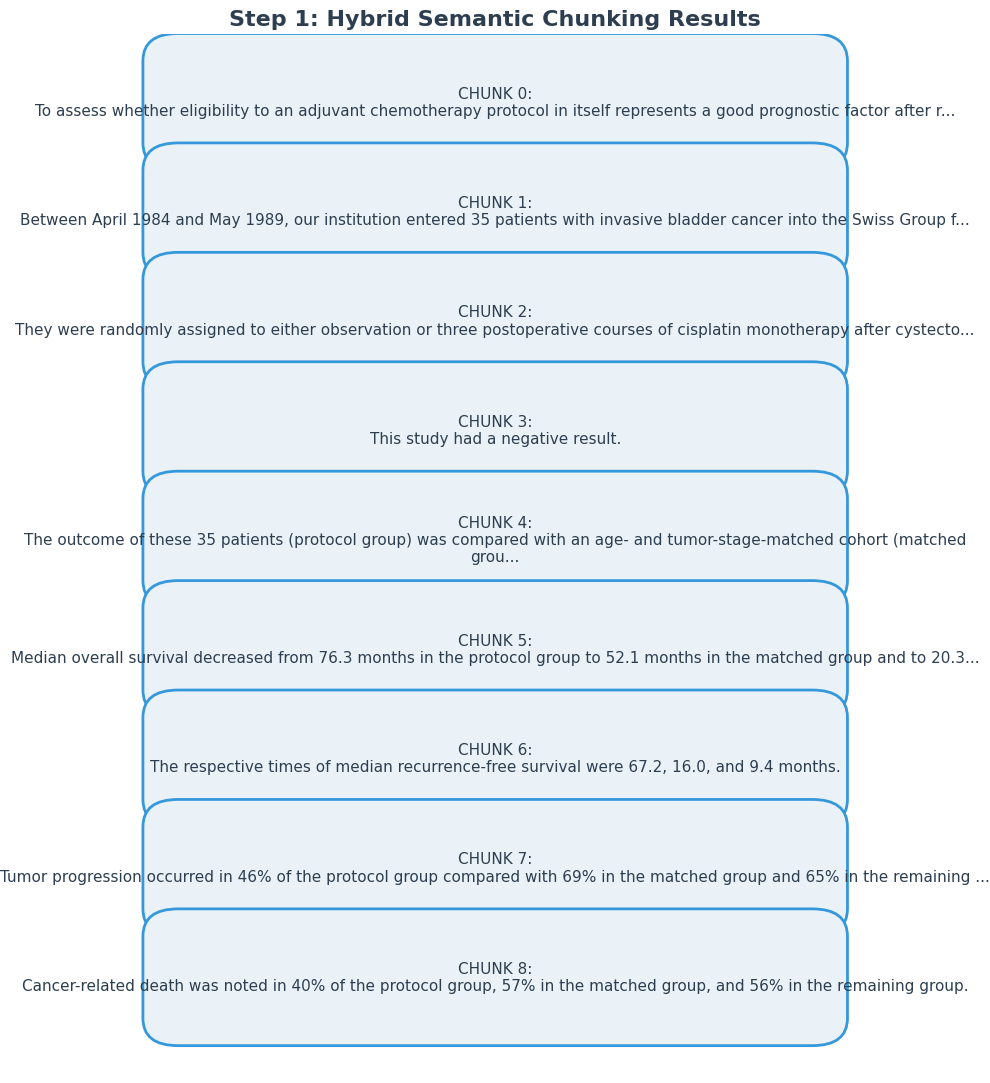

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 2 & 3] Constructing Hierarchical Graph (Docs -> Entities -> Definitions)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

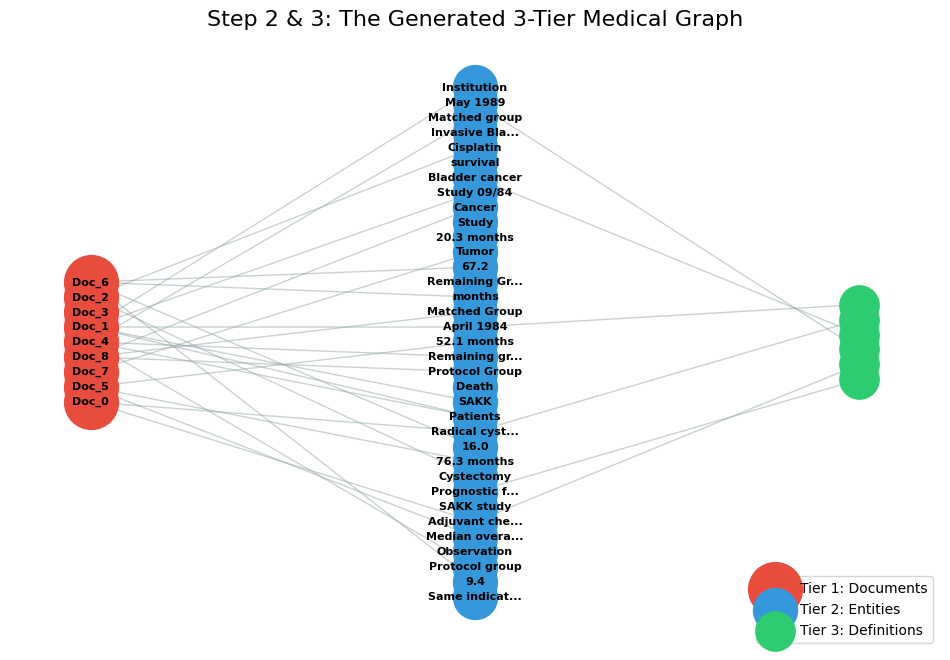

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Is eligibility for a chemotherapy protocol a good prognostic factor for invasive bladder cancer after radical cystectomy?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/tmp/ipython-input-1900433473.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_scores, x='Similarity', y='Tag', palette='viridis')


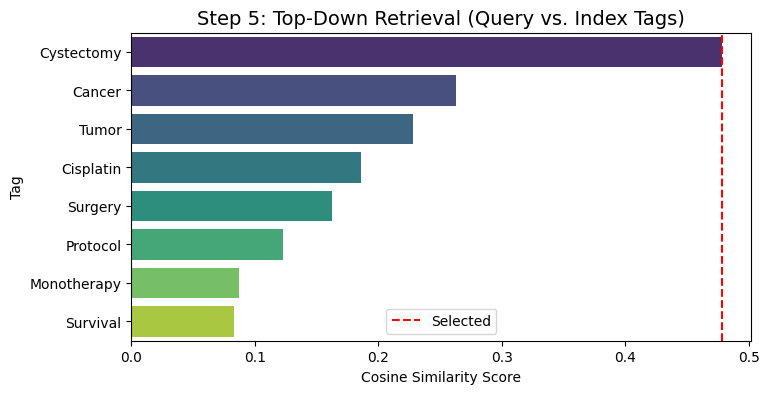

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🧠 [Slide Text: Reasoning Chain]
----------------------------------------
Here's my answer:

1. The graph shows that patients in the protocol group have a significantly better overall survival rate (OS) compared to the matched group and remaining group. This suggests that eligibility for the chemotherapy protocol is associated with a better prognosis. Furthermore, the OS rates of the protocol group are not significantly different from the expected OS rates, indicating that this group has a similar prognosis to the general population.
FINAL LABEL: YES
----------------------------------------
Truth: YES | Prediction: YES
Result: ✅ CORRECT


############################################################
🎬 GENERATING SLIDES FOR SAMPLE 2: Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?
############################################################

🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The purpose of this study was to retrospectively assess the potential benefits of delayed phase imaging series in routine CT scans of the abdomen and pelvis.', 'Routine contrast-enhanced abdominopelvic CT scans of 1000 consecutively examined patients (912 men, 88 women; average age, 60 years; range, 22-94 years) were retrospectively evaluated, and the added benefits of the delayed phase series through the abdomen were recorded for each examination.', 'Examinations performed for indications requiring multiphasic imaging were excluded.', 'Images were reviewed by two fellowship-trained abdominal radiologists, who were blinded to official CT reports.', 'All examinations were performed between July 2008 and February 2010 at a single institution.', 'Radiation doses for both the portal venous and delayed phases, when available, were analyzed to assess the effect of the delayed phase on overall radiation exposure.', 'Forty-two patients (4.2%) had findings that were further characteri

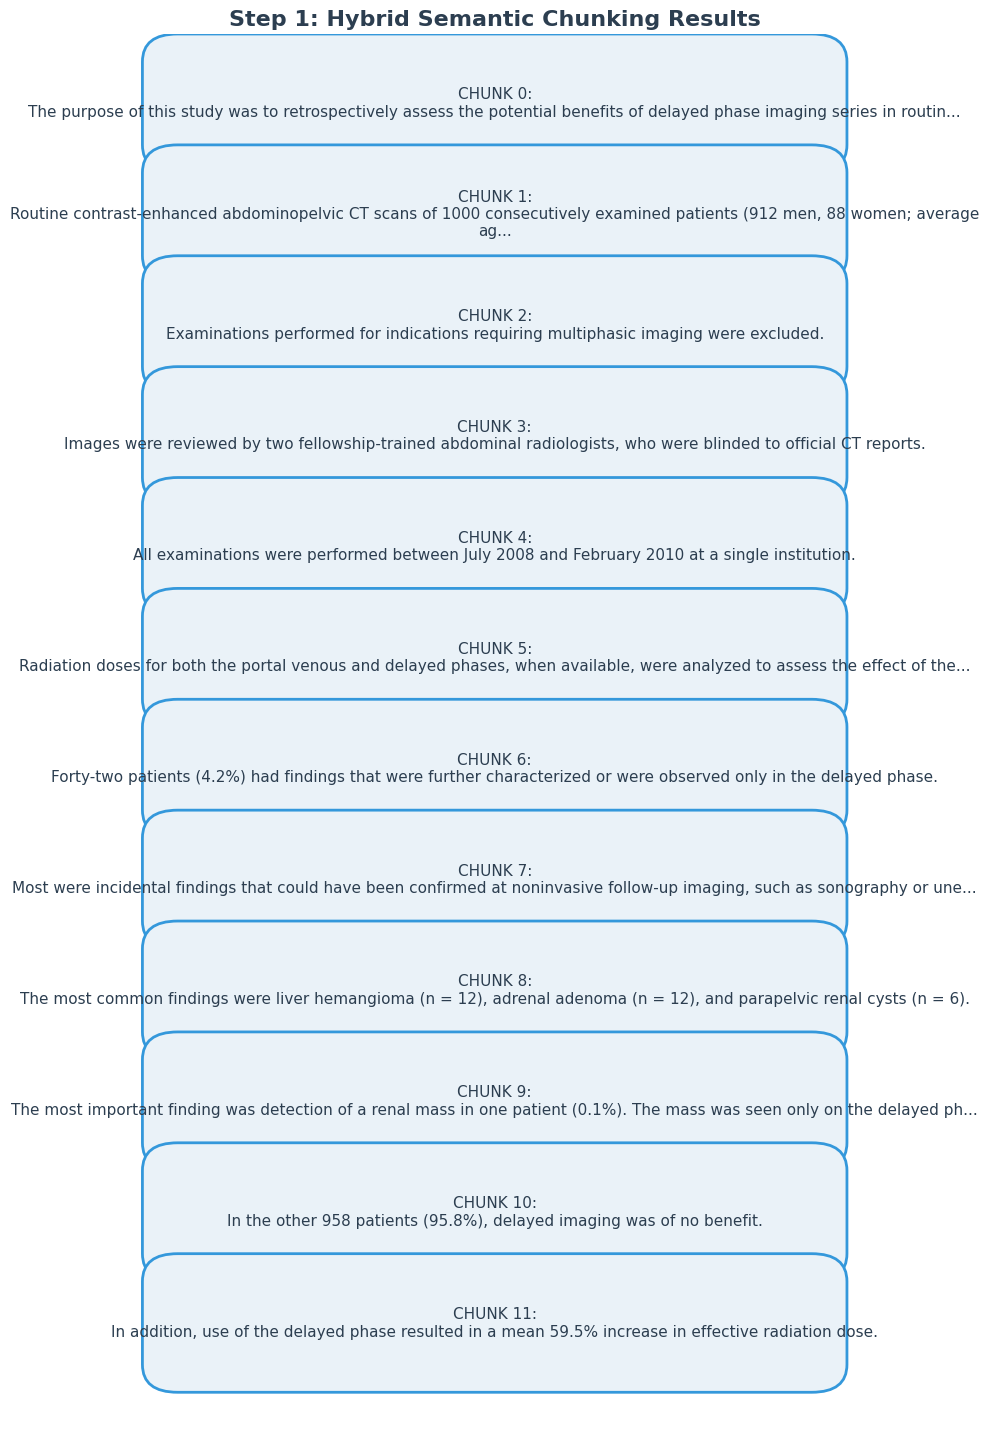

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 2 & 3] Constructing Hierarchical Graph (Docs -> Entities -> Definitions)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

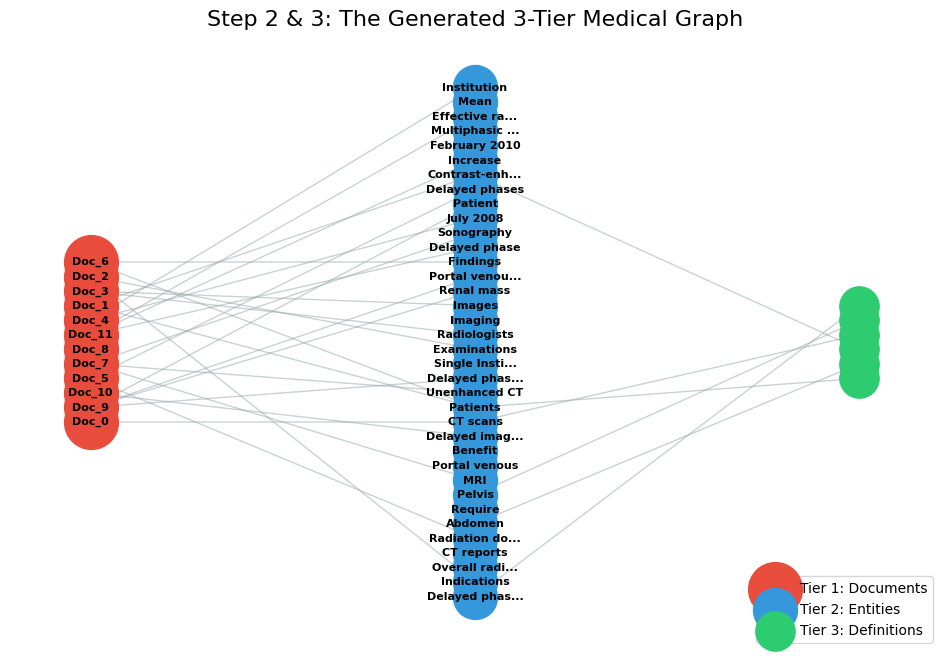

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/tmp/ipython-input-1900433473.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False`

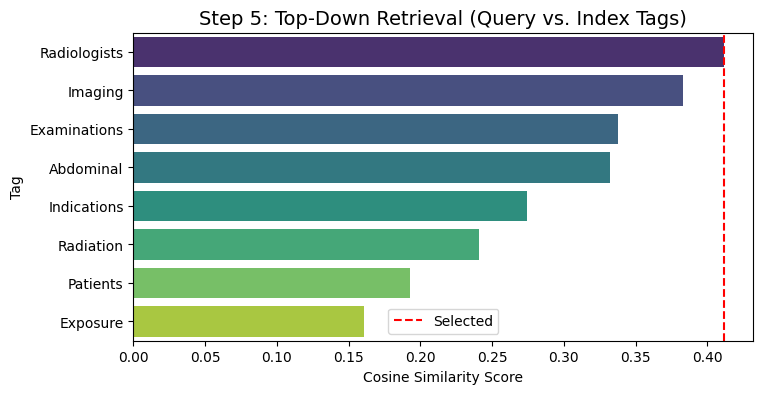

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🧠 [Slide Text: Reasoning Chain]
----------------------------------------
Here's my answer:

Reasoning chain:
The graph shows that radiologists were able to accurately diagnose abdominal and pelvic conditions with delayed imaging, which means that the additional cost and radiation exposure may not be necessary for optimal diagnosis. The radiologists were blinded to official CT reports, indicating that the delayed imaging did not compromise diagnostic accuracy. Therefore, it is reasonable to conclude that delayed imaging may not be worth the additional cost and radiation exposure.

FINAL LABEL: NO
----------------------------------------
Truth: NO | Prediction: NO
Result: ✅ CORRECT


############################################################
🎬 GENERATING SLIDES FOR SAMPLE 3: Does the SCL 90-R obsessive-compulsive dimension identify cognitive impairments?
############################################################

🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To investigate the relevance of the Symptom Checklist 90-R Obsessive-Compulsive subscale to cognition in individuals with brain tumor.', 'A prospective study of patients assessed with a neuropsychological test battery.', 'A university medical center. Nineteen adults with biopsy-confirmed diagnoses of malignant brain tumors were assessed prior to aggressive chemotherapy.', 'Included in the assessment were the Mattis Dementia Rating Scale, California Verbal Learning Test, Trail Making Test B, Symptom Checklist 90-R, Mood Assessment Scale, Beck Anxiety Inventory, and Chronic Illness Problem Inventory.', 'The SCL 90-R Obsessive-Compulsive subscale was not related to objective measures of attention, verbal memory, or age.', 'It was related significantly to symptoms of depression (r = .81, P<.005), anxiety (r = .66, P<.005), and subjective complaints of memory problems (r = .75, P<.005).', 'Multivariate analyses indicated that reported symptoms of depression contributed 66% of the 

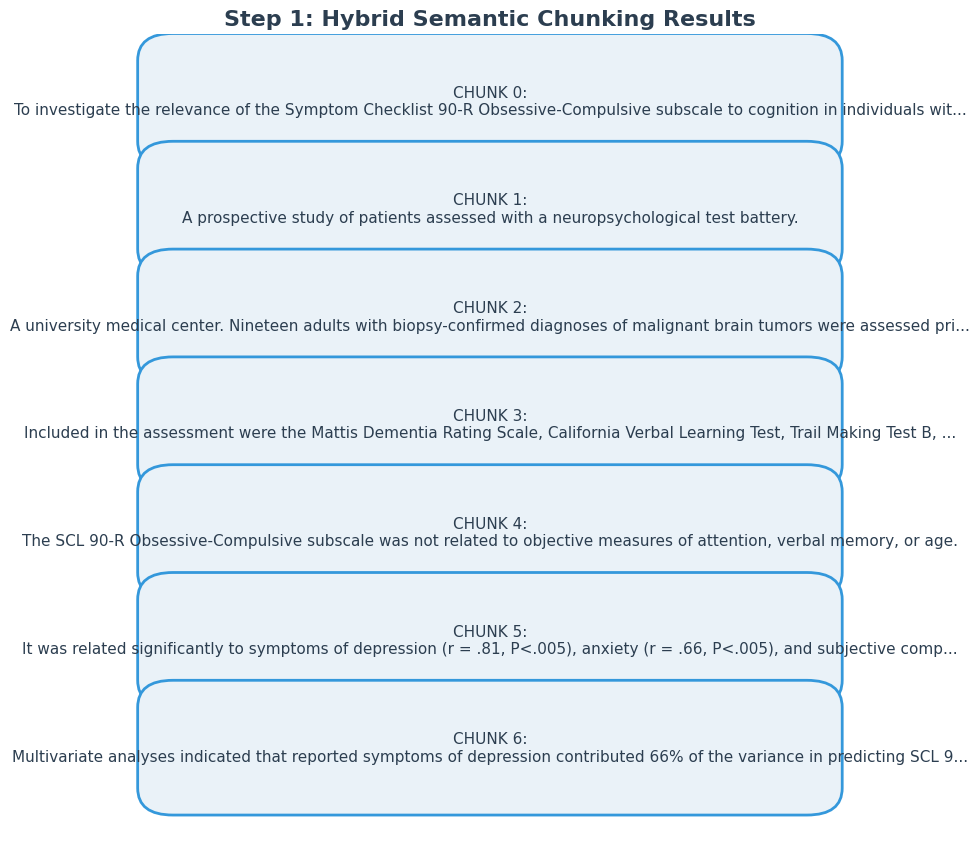

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 2 & 3] Constructing Hierarchical Graph (Docs -> Entities -> Definitions)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


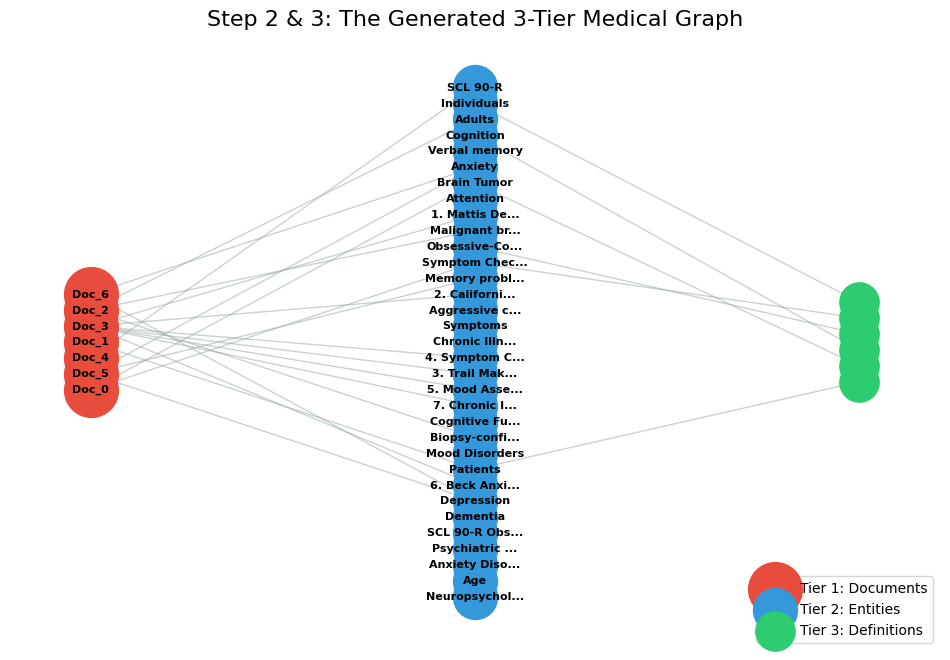

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does the SCL 90-R obsessive-compulsive dimension identify cognitive impairments?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/tmp/ipython-input-1900433473.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_scores, x='Similarity', y='Tag', palette='viridis')


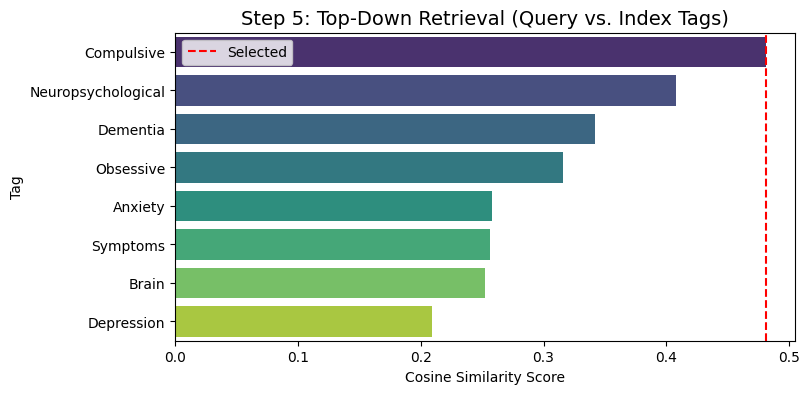

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...

🧠 [Slide Text: Reasoning Chain]
----------------------------------------
Here's the reasoning chain:

The SCL 90-R Obsessive-Compulsive subscale was not related to objective measures of attention, verbal memory, or age. This suggests that the subscale is not a strong predictor of cognitive impairments. Therefore, it is unlikely that the SCL 90-R obsessive-compulsive dimension identifies cognitive impairments.

FINAL LABEL: NO
----------------------------------------
Truth: YES | Prediction: NO
Result: ❌ INCORRECT



In [ ]:
# @title 📸 Generate Visuals for Specific Slides (Samples 0, 1, 2)

# 1. Define the 3 Samples Manually (Copied from your logs)
target_samples = [
    {
        'id': 'Slide_Sample_1',
        'question': 'Is eligibility for a chemotherapy protocol a good prognostic factor for invasive bladder cancer after radical cystectomy?',
        'truth': 'yes',
        'context': ['To assess whether eligibility to an adjuvant chemotherapy protocol in itself represents a good prognostic factor after radical cystectomy for bladder cancer.', 'Between April 1984 and May 1989, our institution entered 35 patients with invasive bladder cancer into the Swiss Group for Clinical and Epidemiological Cancer Research (SAKK) study 09/84. They were randomly assigned to either observation or three postoperative courses of cisplatin monotherapy after cystectomy. This study had a negative result. The outcome of these 35 patients (protocol group) was compared with an age- and tumor-stage-matched cohort (matched group; n = 35) who also underwent cystectomy during the same period, but were not entered into the SAKK study, as well as the remaining 57 patients treated during the study period for the same indication (remaining group).', 'Median overall survival decreased from 76.3 months in the protocol group to 52.1 months in the matched group and to 20.3 months in the remaining group. The respective times of median recurrence-free survival were 67.2, 16.0, and 9.4 months. Tumor progression occurred in 46% of the protocol group compared with 69% in the matched group and 65% in the remaining group (P<.05). Cancer-related death was noted in 40% of the protocol group, 57% in the matched group, and 56% in the remaining group.']
    },
    {
        'id': 'Slide_Sample_2',
        'question': 'Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?',
        'truth': 'no',
        'context': ['The purpose of this study was to retrospectively assess the potential benefits of delayed phase imaging series in routine CT scans of the abdomen and pelvis.', 'Routine contrast-enhanced abdominopelvic CT scans of 1000 consecutively examined patients (912 men, 88 women; average age, 60 years; range, 22-94 years) were retrospectively evaluated, and the added benefits of the delayed phase series through the abdomen were recorded for each examination. Examinations performed for indications requiring multiphasic imaging were excluded. Images were reviewed by two fellowship-trained abdominal radiologists, who were blinded to official CT reports. All examinations were performed between July 2008 and February 2010 at a single institution. Radiation doses for both the portal venous and delayed phases, when available, were analyzed to assess the effect of the delayed phase on overall radiation exposure.', 'Forty-two patients (4.2%) had findings that were further characterized or were observed only in the delayed phase. Most were incidental findings that could have been confirmed at noninvasive follow-up imaging, such as sonography or unenhanced CT or MRI. The most common findings were liver hemangioma (n = 12), adrenal adenoma (n = 12), and parapelvic renal cysts (n = 6). The most important finding was detection of a renal mass in one patient (0.1%). The mass was seen only on the delayed phase images but was difficult to appreciate in the portal venous phase. In the other 958 patients (95.8%), delayed imaging was of no benefit. In addition, use of the delayed phase resulted in a mean 59.5% increase in effective radiation dose.']
    },
    {
        'id': 'Slide_Sample_3',
        'question': 'Does the SCL 90-R obsessive-compulsive dimension identify cognitive impairments?',
        'truth': 'yes',
        'context': ['To investigate the relevance of the Symptom Checklist 90-R Obsessive-Compulsive subscale to cognition in individuals with brain tumor.', 'A prospective study of patients assessed with a neuropsychological test battery.', 'A university medical center.', 'Nineteen adults with biopsy-confirmed diagnoses of malignant brain tumors were assessed prior to aggressive chemotherapy.', 'Included in the assessment were the Mattis Dementia Rating Scale, California Verbal Learning Test, Trail Making Test B, Symptom Checklist 90-R, Mood Assessment Scale, Beck Anxiety Inventory, and Chronic Illness Problem Inventory.', 'The SCL 90-R Obsessive-Compulsive subscale was not related to objective measures of attention, verbal memory, or age. It was related significantly to symptoms of depression (r = .81, P<.005), anxiety (r = .66, P<.005), and subjective complaints of memory problems (r = .75, P<.005). Multivariate analyses indicated that reported symptoms of depression contributed 66% of the variance in predicting SCL 90-R Obsessive-Compulsive Scores, whereas symptoms of anxiety contributed an additional 6% (P<.0001).']
    }
]

def generate_slide_visuals(sample_list):
    for i, s in enumerate(sample_list):
        print(f"\n{'#'*60}")
        print(f"🎬 GENERATING SLIDES FOR SAMPLE {i+1}: {s['question']}")
        print(f"{'#'*60}\n")

        # Prepare Text
        full_text = " ".join(s['context'])

        # 1. Chunking Plot
        chunks = step1_semantic_chunking(full_text, visualize=True)

        # 2. Graph Plot
        G = step2_3_build_graph(chunks, visualize=True)

        # 3. Retrieval Plot
        evidence = step4_5_u_retrieval(G, s['question'], visualize=True)

        # 4. Final Reasoning Output (Clean Text for Slide)
        raw_resp, pred = generate_answer(s['question'], evidence)

        print(f"\n🧠 [Slide Text: Reasoning Chain]")
        print("-" * 40)
        print(raw_resp)
        print("-" * 40)
        print(f"Truth: {s['truth'].upper()} | Prediction: {pred.upper()}")
        print(f"Result: {'✅ CORRECT' if s['truth'] == pred else '❌ INCORRECT'}\n")

# Run it
generate_slide_visuals(target_samples)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# @title 🚀 1. Define Agent V6 (Anti-Looping)
import json

class MedicalGraphAgent:
    def __init__(self, G, llm_func, embed_model):
        self.G = G.to_undirected()
        self.ask_llm = llm_func
        self.embed_model = embed_model
        self.history = []
        self.max_steps = 4
        self.visited = set() # Memory of where we have been

    def find_start_node(self, question):
        entities = [n for n, d in self.G.nodes(data=True) if d.get('type') == 'entity']
        if not entities: return None
        q_emb = self.embed_model.encode(question)
        e_emb = self.embed_model.encode(entities)
        scores = util.cos_sim(q_emb, e_emb)[0]
        best_idx = torch.argmax(scores).item()
        return entities[best_idx]

    def get_neighbors_info(self, node):
        neighbors = list(self.G.neighbors(node))
        options = []
        valid_indices = []

        for i, n in enumerate(neighbors):
            # Anti-Looping: Don't show nodes we just visited
            if n in self.visited: continue

            ntype = self.G.nodes[n].get('type', 'unknown')
            if ntype in ['definition', 'document']:
                txt = self.G.nodes[n].get('text', '')[:50]
                options.append(f"{i}: {n} ({ntype}: {txt}...)")
            else:
                options.append(f"{i}: {n} ({ntype})")
            valid_indices.append(i)

        return options, neighbors, valid_indices

    def step(self, current_node, question):
        options_text, neighbors, valid_indices = self.get_neighbors_info(current_node)

        # If all neighbors are visited, we are stuck. Force stop.
        if not options_text:
            return {"thought": "All neighbors visited. Stopping.", "next_id": "STOP"}, neighbors

        options_str = "\n".join([f"   {o}" for o in options_text])

        prompt = f"""
        You are a medical graph navigator.
        GOAL: Answer "{question}"

        CURRENT NODE: {current_node}
        NEIGHBORS (Select by ID):
        {options_str}

        HISTORY: {self.history}

        Task:
        1. Choose the ID (number) of the unvisited neighbor that helps answer the question.
        2. IF you see a 'document' node, GO THERE. It likely has the answer.
        3. If you have the answer, output "STOP".

        Format strictly as JSON:
        {{
            "thought": "Reasoning...",
            "next_id": "Integer ID (e.g. 0) OR 'STOP'"
        }}
        """

        try:
            resp = self.ask_llm(prompt, max_tokens=150)
            if "{" in resp:
                json_str = resp[resp.find('{'):resp.rfind('}')+1]
                decision = json.loads(json_str)
            else:
                decision = {"thought": "Formatting Error", "next_id": "STOP"}
        except:
            decision = {"thought": "Error", "next_id": "STOP"}

        return decision, neighbors

    def navigate(self, question):
        start_node = self.find_start_node(question)
        if not start_node: return "No start node", "maybe", []

        curr = start_node
        self.history = [f"START: {curr}"]
        self.visited = {curr} # Mark start as visited
        path_log = [curr]
        final_ans = "No answer found."

        print(f"   🤖 Agent starts at: {curr}")

        for i in range(self.max_steps):
            decision, neighbors = self.step(curr, question)
            thought = decision.get('thought', '')
            next_id = decision.get('next_id', 'STOP')

            print(f"      Step {i+1}: {thought} -> GO: ID {next_id}")

            if str(next_id).upper() == "STOP" or "STOP" in thought:
                final_ans = thought
                break

            try:
                idx = int(next_id)
                # Robust Logic
                if idx < 0: idx = 0
                if idx >= len(neighbors): idx = len(neighbors) - 1

                curr = neighbors[idx]

                # Double check visited
                if curr in self.visited:
                    print(f"      ⚠️ Already visited {curr}. Stopping loop.")
                    break

                self.visited.add(curr)
                self.history.append(f"Moved to {curr}")
                path_log.append(curr)
            except:
                break

        label = "maybe"
        if "YES" in final_ans.upper(): label = "yes"
        elif "NO" in final_ans.upper(): label = "no"
        return final_ans, label, path_log

In [ ]:
# @title ⚔️ Head-to-Head: Run Agent on the SAME 20 Samples (Final Version)
def run_agent_head_to_head(limit=20):
    print(f"🚀 Starting Agentic Benchmark on SAME {limit} samples...")
    print("⏳ Note: This takes longer than Baseline because the Agent 'thinks' multiple times per sample.\n")

    # 1. Load SAME Data (Seed 42 guarantees identical samples to Baseline)
    data = load_dataset("pubmed_qa", "pqa_labeled", split="train")
    samples = data.shuffle(seed=42).select(range(limit))

    correct_count = 0
    detailed_results = []

    for i, s in enumerate(tqdm(samples)):
        try:
            # A. Build Graph (Same Environment)
            chunks = step1_semantic_chunking(" ".join(s['context']['contexts']), visualize=False)
            G = step2_3_build_graph(chunks, visualize=False)

            # B. Initialize Agent
            agent = MedicalGraphAgent(G, ask_llm, embed_model)

            # C. Run Agent Navigation (Now accepts 3 values!)
            final_reasoning, pred_label, path = agent.navigate(s['question'])

            # D. Score
            truth = s['final_decision']
            is_correct = (pred_label == truth)

            if is_correct:
                correct_count += 1

            # Log for comparison
            detailed_results.append({
                "id": i,
                "truth": truth,
                "agent_pred": pred_label,
                "correct": is_correct,
                "path": path
            })

        except Exception as e:
            print(f"   ⚠️ Error on sample {i}: {e}")
            detailed_results.append({"id": i, "correct": False, "error": str(e)})

    # Final Stats
    acc = (correct_count / limit) * 100
    print(f"\n{'='*40}")
    print(f"🏆 FINAL AGENT ACCURACY: {acc:.2f}%")
    print(f"{'='*40}")

    return acc, detailed_results

# --- EXECUTE ---
agent_acc, agent_results = run_agent_head_to_head(limit=20)

🚀 Starting Agentic Benchmark on SAME 20 samples...
⏳ Note: This takes longer than Baseline because the Agent 'thinks' multiple times per sample.



  0%|          | 0/20 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To assess whether eligibility to an adjuvant chemotherapy protocol in itself represents a good prognostic factor after radical cystectomy for bladder cancer.', 'Between April 1984 and May 1989, our institution entered 35 patients with invasive bladder cancer into the Swiss Group for Clinical and Epidemiological Cancer Research (SAKK) study 09/84.', 'They were randomly assigned to either observation or three postoperative courses of cisplatin monotherapy after cystectomy.', 'This study had a negative result.', 'The outcome of these 35 patients (protocol group) was compared with an age- and tumor-stage-matched cohort (matched group; n = 35) who also underwent cystectomy during the same period, but were not entered into the SAKK study, as well as the remaining 57 patients treated during the study period for the same indication (remaining group).', 'Median overall survival decreased from 76.3 months in the protocol group to 52.1 months in the matched group and to 20.3 months in t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Invasive Bladder Cancer


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: Let's explore the Patients node to see if it has any information about chemotherapy protocol eligibility and its relationship with invasive bladder cancer prognosis. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: I'm currently at the 'Patients' node, which doesn't seem to have the answer. Let me explore the neighbors to see if any of them can help me answer the question. -> GO: ID 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: I'm in the Remaining group, which is a subset of patients. I need to explore further to find the answer. I'll choose the neighbor with the most potential to provide the answer. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 4: I'm at Doc_4, which seems like a good spot to explore. I have two neighbors: Protocol group and Matched group. I'll choose the Protocol group to see if it has any information about chemotherapy protocols. -> GO: ID 1
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The purpose of this study was to retrospectively assess the potential benefits of delayed phase imaging series in routine CT scans of the abdomen and pelvis.', 'Routine contrast-enhanced abdominopelvic CT scans of 1000 consecutively examined patients (912 men, 88 women; average age, 60 years; range, 22-94 years) were retrospectively evaluated, and the added benefits of the delayed phase series through the abdomen were recorded for each examination.', 'Examinations performed for indications requiring multiphasic imaging were excluded.', 'Images were reviewed by two fellowship-trained abdominal radiologists, who were blinded to official CT reports.', 'All examinations were performed between July 2008 and February 2010 at a single institution.', 'Radiation doses for both the portal venous and delayed phases, when available, were analyzed to assess the effect of the delayed phase on overall radiation exposure.', 'Forty-two patients (4.2%) had findings that were further characteri

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: CT scans


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: I'm starting at the current node, CT scans, to explore the question of delayed imaging in routine CT examinations of the abdomen and pelvis. -> GO: ID 3
      Step 2: All neighbors visited. Stopping. -> GO: ID STOP
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To investigate the relevance of the Symptom Checklist 90-R Obsessive-Compulsive subscale to cognition in individuals with brain tumor.', 'A prospective study of patients assessed with a neuropsychological test battery.', 'A university medical center. Nineteen adults with biopsy-confirmed diagnoses of malignant brain tumors were assessed prior to aggressive chemotherapy.', 'Included in the assessment were the Mattis Dementia Rating Scale, California Verbal Learning Test, Trail Making Test B, Symptom Checklist 90-R, Mood Assessment Scale, Beck Anxiety Inventory, and Chronic Illness Problem Inventory.', 'The SCL 90-R Obsessive-Compulsive subscale was not related to objective measures of attention, verbal memory, or age.', 'It was related significantly to symptoms of depression (r = .81, P<.005), anxiety (r = .66, P<.005), and subjective complaints of memory problems (r = .75, P<.005).', 'Multivariate analyses indicated that reported symptoms of depression contributed 66% of the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   🤖 Agent starts at: SCL 90-R Obsessive-Compulsive Scores


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: The SCL 90-R obsessive-compulsive dimension might be related to cognitive impairments, but I need to explore further. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: Since we're currently at the 'Anxiety' node, I'll explore the neighboring nodes to see if any of them can help answer the question. The 'Symptoms' node seems like a good place to start, as it might provide some insight into cognitive impairments. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: The SCL 90-R obsessive-compulsive dimension doesn't seem to be directly related to cognitive impairments, so I'll explore other options. -> GO: ID 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 4: Since we're currently at the 'Memory problems' node, I'll explore the neighbor that might help us identify cognitive impairments related to obsessive-compulsive symptoms. -> GO: ID 0
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Treatment of HBeAg-negative chronic hepatitis B (CHB) with nucleos(t)ide analogues (NA) is usually indefinite, since the loss of HBsAg, as a criterion for its discontinuation, is a rare event. Recent evidence suggests that discontinuing NA therapy may be feasible in selected patients.', 'To analyze the rate of virological relapse in patients with HBeAg-negative CHB who discontinued treatment with NAs.', 'We performed a single-center observational study that included 140 patients with HBsAg-negative CHB. Twenty-two patients, who received only NAs, discontinued treatment for different reasons and were subsequently monitored.', 'All had normal ALT and AST, undetectable DNA and absence of cirrhosis or significant comorbidities before stopping treatment.', 'Twelve patients showed virologic relapse (54.54%).', 'The mean interval between discontinuation and relapse was 6.38 months (± 1.9) (75% relapsed during the first 12 months after discontinuation).', 'Five received adefovir, 1 l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: HBeAg-negative chronic hepatitis B (CHB)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: I'm currently at the HBeAg-negative chronic hepatitis B (CHB) node, and I need to explore a neighbor to help answer the question. I'll choose the neighbor with the most relevant information. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: Since we're currently at the nucleos(t)ide analogues (NA) node, and we're trying to determine if it's possible to stop treatment with NA in patients with e-antigen negative chronic hepatitis B, let's explore the HBsAg node to see if it provides any insight. -> GO: ID 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: Since we're currently at HBsAg, I'll explore the neighbor that might provide more context about the treatment. Let's see what Doc_0 has to say. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 4: Since we're currently at Doc_0, let's explore the neighbor that might help us answer the question. The neighbor is 'Nucleos(t)ide analogues (NA)', which is relevant to the current topic of chronic hepatitis B treatment. -> GO: ID 1
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ["The rate of aortic aneurysm rupture correlates with the aneurysm's diameter, and a higher rate of rupture is observed in patients with larger aneurysms.", "According to the literature, contradictory results concerning the relationship between atmospheric pressure and aneurysm size have been reported.AIM: In this paper, we assessed the influence of changes in atmospheric pressure on abdominal aneurysm ruptures in relationship to the aneurysm's size.", 'The records of 223 patients with ruptured abdominal aneurysms were evaluated. All of the patients had been admitted to the department in the period 1997-2007 from the Silesia region.', 'The atmospheric pressures on the day of the rupture and on the days both before the rupture and between the rupture events were compared.', 'The size of the aneurysm was also considered in the analysis.', 'There were no statistically significant differences in pressure between the days of rupture and the remainder of the days within an analysed p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Aortic aneurysms


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: To understand the influence of atmospheric pressure on aortic aneurysm rupture, I need to explore the relationship between atmospheric pressure and the diameter of the aneurysm. -> GO: ID 1
      Step 2: All neighbors visited. Stopping. -> GO: ID STOP
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['This study aims to examine the accuracy of a new sternal skin conductance (SSC) device in measuring hot flashes and to assess the acceptability of the device by women.', 'Three small descriptive pilot studies were performed using two sequential prototypes of the SSC device developed by an engineering device company in the Midwest.', 'The devices were worn either in a monitored setting for 24 hours or in an ambulatory setting for 5 weeks.', 'During the study period, women recorded hot flashes in a prospective hot flash diary and answered questions about the acceptability of wearing the SSC device.', 'The first prototype was not able to collect any analyzable skin conductance data owing to various malfunction issues, including poor conductance and battery failure.', 'However, 16 women wore the device for 5 weeks and reported that wearing the device was acceptable, although 31% stated that it interfered with daily activities.', 'Hot flash data from the second prototype revealed 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   🤖 Agent starts at: Sternal skin conductance (SSC) device


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: I'm considering the possibility that sternal skin conductance (SSC) could be a reasonable surrogate for hot flash measurement. Let me explore the neighbors to see if I can find a connection. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: I'm trying to determine if sternal skin conductance is a reasonable surrogate for hot flash measurement. Since I'm currently at the 'hot flashes' node, I'll explore the neighbor that provides more information about hot flashes. -> GO: ID 1
      Step 3: All neighbors visited. Stopping. -> GO: ID STOP
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: [': A previous hip fracture more than doubles the risk of a contralateral hip fracture.', 'Pharmacologic and environmental interventions to prevent hip fracture have documented poor compliance.', 'The purpose of this study was to examine the cost-effectiveness of prophylactic fixation of the uninjured hip to prevent contralateral hip fracture.', ': A Markov state-transition model was used to evaluate the cost and quality-adjusted life-years (QALYs) for unilateral fixation of hip fracture alone (including internal fixation or arthroplasty) compared with unilateral fixation and contralateral prophylactic hip fixation performed at the time of hip fracture or unilateral fixation and bilateral hip pad protection.', 'Prophylactic fixation involved placement of a cephalomedullary nail in the uninjured hip and was initially assumed to have a relative risk of a contralateral fracture of 1%.', 'Health states included good health, surgery-related complications requiring a second operation

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Contralateral prophylactic hip fixation


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: I'm considering the neighbor 'Hip fracture' to understand the relationship between contralateral prophylactic hip fixation and the risk of future hip fractures. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: I'm trying to determine if prophylactic fixation is a cost-effective method to prevent a future contralateral fragility hip fracture. I'll explore the neighbors to find the answer. -> GO: ID 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: I'm at Doc_3, and I need to explore the neighbor that might help me answer the question. Let's see what's next door. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 4: Since we're currently at Unilateral fixation, I'll explore the neighbor that might provide more insight into prophylactic fixation. Let's head to Internal fixation (entity) to see if it has any relevant information. -> GO: ID 2
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['More than 1000 candidates applied for orthopaedic residency positions in 2014, and the competition is intense; approximately one-third of the candidates failed to secure a position in the match.', 'However, the criteria used in the selection process often are subjective and studies have differed in terms of which criteria predict either objective measures or subjective ratings of resident performance by faculty.QUESTIONS/ Do preresidency selection factors serve as predictors of success in residency?', 'Specifically, we asked which preresidency selection factors are associated or correlated with (1) objective measures of resident knowledge and performance; and (2) subjective ratings by faculty.', 'Charts of 60 orthopaedic residents from our institution were reviewed.', 'Preresidency selection criteria examined included United States Medical Licensing Examination (USMLE) Step 1 and Step 2 scores, Medical College Admission Test (MCAT) scores, number of clinical clerkship honors,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Orthopaedic Residency Positions


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: To answer this question, I need to explore the candidates who are applying for orthopaedic residency positions. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: I'm trying to determine if residency selection criteria predict performance in orthopaedic surgery residency. Let's explore the candidates. -> GO: ID 0
      Step 3: All neighbors visited. Stopping. -> GO: ID STOP
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The purpose of this study is to determine if baseline antral follicle assessment may serve as additional information in predicting in vitro fertilization outcome.', 'Prospective, descriptive preliminary study of in vitro fertilization outcome. From July 1998 to July 1999, 224 patients underwent antral follicle assessment (follicle 2-6 mm in diameter) on baseline of the planned, stimulated in vitro fertilization cycle.', 'The outcomes were analyzed with respect to antral follicle assessment (<or = 6 or>6), basal cycle day 3 follicle stimulated hormone (<or = 10 or>10 IU/L) and maternal age (<or = 35 or>35 years).', 'The clinical pregnancy rate was significantly higher in the group with baseline antral follicle>6 compared to that in the group with antral follicle<or = 6 (51% vs. 19%, respectively).', 'Controlling for patient age, and basal follicle stimulated hormone, the pregnancy rate was significantly higher in the group with antral follicle>6 compared to that in the group w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   🤖 Agent starts at: Antral follicle assessment


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: I'm currently at the Antral follicle assessment node, and I want to explore whether it's a better predictor than age and FSH. Let me check the neighboring nodes to see if any of them have the answer. -> GO: ID 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: I'm currently at Doc_2, and I'm trying to determine if antral follicle assessment is a better predictor than age and FSH for IVF outcomes. I'd like to explore the neighbor with ID 1, Basal cycle day 3 follicle stimulated hormone (entity), to see if it provides any insights. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: Considering the current node is Basal cycle day 3 follicle stimulated hormone, I think it's essential to explore the relationship between antral follicle assessment and maternal age, as both are relevant to predicting IVF outcomes. -> GO: ID 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 4: I'm currently at Maternal age, which is a factor in predicting IVF outcomes. However, I'm looking for a better predictor than age and FSH. I'll explore the neighbors to see if any of them provide a better answer. -> GO: ID 2
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To examine survival with and without a percutaneous endoscopic gastrostomy (PEG) feeding tube using rigorous methods to account for selection bias and to examine whether the timing of feeding tube insertion affected survival.', 'Prospective cohort study.', 'All U.S. nursing homes (NHs). Thirty-six thousand four hundred ninety-two NH residents with advanced cognitive impairment from dementia and new problems eating studied between 1999 and 2007.', 'Survival after development of the need for eating assistance and feeding tube insertion.', 'Of the 36,492 NH residents (88.4% white, mean age 84.9, 87.4% with one feeding tube risk factor), 1,957 (5.4%) had a feeding tube inserted within 1\xa0year of developing eating problems.', 'After multivariate analysis correcting for selection bias with propensity score weights, no difference was found in survival between the two groups (adjusted hazard ratio (AHR)\xa0=\xa01.03, 95% confidence interval (CI)\xa0=\xa00.94-1.13).', 'In residents 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   🤖 Agent starts at: Timing of Feeding Tube Insertion


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: To answer the question 'Does feeding tube insertion and its timing improve survival?', I need to explore the neighbor that provides more information about survival. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: To examine survival with and without a feeding tube insertion, I'll explore the 'Feeding Tube' neighbor. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: I'm trying to determine if feeding tube insertion and its timing improve survival. I'll explore the neighbors to see if I can find the answer. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 4: I'm starting at Doc_0, and I see a neighbor called PEG. Let's explore that. -> GO: ID 0
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To examine the impact of early discharge on newborn metabolic screening.', 'Metabolic screening results were obtained from the Alabama State Lab for all infants born at our hospital between 8/1/97, and 1/31/99, and were matched with an existing database of early discharge infants.', 'An early newborn discharge was defined as a discharge between 24 and 47 hours of age.', 'Metabolic screening tests included phenylketonuria (PKU), hypothyroidism, and congenital adrenal hyperplasia (CAH).', 'Early discharge and traditional stay infants were compared to determine the percentage of newborns screened and the timing of the first adequate specimen. The state laboratory received specimens from 3860 infants; 1324 were on early discharge newborns and 2536 infants in the traditional stay group.', 'At least one filter paper test (PKU, hypothyroidism, and CAH) was collected on 99.2% of early discharge infants and 96.0% of traditional stay infants (P<.0001).', 'Early discharge infants had a 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Early discharge newborns


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: I'm currently at the 'Early discharge newborns' node, and I'm trying to determine if early discharge with nurse home visits affects the adequacy of newborn metabolic screening. Let me explore my neighbors to see if I can find the answer. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: I'm at Doc_4, and I need to explore the neighbors to find the answer. Infants might have some relevant information, but State laboratory could be a good lead. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: I'm currently at the State laboratory, which is a good starting point for investigating the adequacy of newborn metabolic screening. I have a neighbor, Specimens, which could potentially hold the answer. I'll choose to visit that neighbor. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 4: I'm currently at the Specimens node, which seems to be a dead end. I need to explore the Traditional stay group to see if it has any relevant information. -> GO: ID 2
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The present analysis compares two palliative treatment concepts for lung cancer in terms of overall survival.', 'Survival data from 207\xa0patients were used in a retrospective analysis. All patients received palliative treatment comprising either 25\xa0Gy applied in 5\xa0fractions or 50\xa0Gy in 20\xa0fractions.', 'A subgroup analysis was performed to compare patients with a good-fair vs. poor overall condition.', 'Median survival times were 21\xa0weeks (range\xa06-26\xa0weeks) for patients treated with 25\xa0Gy in 5\xa0fractions and 23\xa0weeks (range\xa014.5-31.5\xa0weeks) for patients treated with 50\xa0Gy in 20\xa0fractions (95\u2009% confidence interval, CI; p\u2009=\u20090.334).', 'For patients with a good-fair overall condition, median survival times were 30\xa0weeks (21.8-39.2\xa0weeks) for 25\xa0Gy in 5\xa0fractions and 28\xa0weeks (14.2-41.8\xa0weeks) for 50\xa0Gy in 20\xa0fractions (CI 95\u2009%, p\u2009=\u20090.694).', 'In patients with a poor overall condition, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   🤖 Agent starts at: Palliative treatment


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: I'm currently at the Palliative treatment node, which is a broad concept. I need to drill down to get more specific information. Let me explore the neighbors. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: Let's explore the patient's characteristics to better understand the question. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: I'm looking for information about palliative lung cancer patients, so I'll explore the 'Overall condition' neighbor to see if it provides any relevant information. -> GO: ID 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 4: Let's explore the definition of overall condition to better understand the context. -> GO: ID 1
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The diagnosis of acute appendicitis is still difficult and the results are unsatisfactory in three particular patient groups: in children, in fertile-age women and in elderly patients.', 'As our population ages, the challenge for expedient diagnosis and intervention in older age groups will become more and more significant.', 'The present study aimed at clarifying the role of leukocyte count and C-reactive protein (CRP) measurements in the diagnosis of acute appendicitis in the elderly.', 'In particular, are there patients with acute appendicitis but unelevated leukocyte count and CRP?', 'Eighty-three consecutive elderly patients underwent appendectomy for suspected acute appendicitis.', 'The mean leukocyte count and CRP value were calculated in patients with an uninflamed appendix (group A) and in those with acute appendicitis (group B).', 'The percentages of patients with: (1) both values unelevated; (2) only leukocyte count elevated; (3) only CRP value elevated; (4) both v

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Diagnosis of acute appendicitis


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: Considering the diagnosis of acute appendicitis in the elderly, I'll explore the role of leukocyte and CRP measurements. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: Considering the current node is Leukocyte count, I'd like to explore the role of CRP measurements in the diagnosis of acute appendicitis in the elderly. Let's move to the CRP neighbor to see if it provides any insights. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: Considering the current node is C-reactive protein (CRP), I'll explore the neighbor Elderly (entity) to see if it provides any insights. -> GO: ID 3
      Step 4: All neighbors visited. Stopping. -> GO: ID STOP
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Although desflurane is commonly used to control surgically induced hypertension, its effects on left ventricular (LV) function have not been investigated in this clinical situation.', 'The purpose of the present study was to evaluate the LV function response to desflurane, when used to control intraoperative hypertension.', 'In 50 patients, scheduled for vascular surgery, anesthesia was induced with sufentanil 0.5 microg/kg, midazolam 0.3 mg/kg and atracurium 0.5 mg/kg. After tracheal intubation, anesthesia was maintained with increments of drugs with controlled ventilation (N2O/O2=60/40%) until the start of surgery.', 'A 5 Mhz transesophageal echocardiography (TEE) probe was inserted after intubation.', 'Pulmonary artery catheter and TEE measurements were obtained after induction (to)(control value), at surgical incision (t1) if it was associated with an increase in systolic arterial pressure (SAP) greater than 140 mmHg (hypertension) and after control of hemodynamic paramet

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Desflurane


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: I'm starting at the Desflurane node, which is a potent inhalational anesthetic agent. I'd like to explore the neighbor that might provide more information about its effects on left ventricular function. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: Since we're currently at the Left Ventricular (LV) function node, I'll explore the neighbor that seems most relevant to the question. Let's visit the 'Def_Left Ventricular (LV) function' node to get a better understanding of what LV function is. -> GO: ID 1
      Step 3: All neighbors visited. Stopping. -> GO: ID STOP
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Celiac disease (CD) is believed to be a permanent intolerance to gluten. A number of patients, however, discontinue the gluten-free diet (GFD) without developing symptoms or signs.', 'The aim of our study was to investigate whether CD patients are capable of developing tolerance to gluten. All 77 adult patients from our hospital known to have biopsy-proven CD for more than 10 years were invited to participate.', 'We investigated symptoms, gluten consumption, antibodies for CD and other autoimmunity, human leukocyte antigen (HLA)-typing, bone mineral density, and performed small bowel biopsies. Tolerance was defined as no immunological or histological signs of CD while consuming gluten.', 'Sixty-six patients accepted participation, but after review of the diagnostic biopsies 53 were found to have true CD.', 'Twenty-three percent of patients had a gluten-containing diet, 15% admitted gluten transgression and 62% followed the GFD. Patients on a GFD had significantly more osteopo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Celiac disease


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: I'm trying to understand gluten tolerance in adult patients with celiac disease 20 years after diagnosis. Let's explore the definition of celiac disease to see if it provides any insight. -> GO: ID 2
      Step 2: All neighbors visited. Stopping. -> GO: ID STOP
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Little is known about the nutritional adequacy and feasibility of breastmilk replacement options recommended by WHO/UNAIDS/UNICEF.', 'The study aim was to explore suitability of the 2001 feeding recommendations for infants of HIV-infected mothers for a rural region in KwaZulu Natal, South Africa specifically with respect to adequacy of micronutrients and essential fatty acids, cost, and preparation times of replacement milks.', 'Nutritional adequacy, cost, and preparation time of home-prepared replacement milks containing powdered full cream milk (PM) and fresh full cream milk (FM) and different micronutrient supplements (2 g UNICEF micronutrient sachet, government supplement routinely available in district public health clinics, and best available liquid paediatric supplement found in local pharmacies) were compared.', 'Costs of locally available ingredients for replacement milk were used to calculate monthly costs for infants aged one, three, and six months.', 'Total monthl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Home-prepared replacement milks


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: Considering the current node is Home-prepared replacement milks, I'll explore the neighbor with ID 0, Doc_2, as it might provide valuable information on the nutritional adequacy, cost, and preparation time of these replacement milks. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: Considering the context of South Africa, I'd like to explore the UNICEF micronutrient sachet, as it's specifically designed to address micronutrient deficiencies in infants. -> GO: ID 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: Considering the current node is UNICEF micronutrient sachet, I'll explore the Micronutrients neighbor to see if it provides the answer. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 4: Considering the importance of micronutrients in infant nutrition, I'll explore the neighbor with the most potential to provide the necessary nutrients. -> GO: ID 0
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ["Some of the disagreements on the perception of dyspnea (PD) during bronchoconstriction in asthma patients could depend on the interrelationships among the following: (1) the influence of baseline airflow obstruction on the patient's ability to detect any further increase in airway resistance; (2) the effect of eosinophilic inflammation on the airway; (3) bronchial hyperresponsiveness (BHR); and (4) the effect of inhaled corticosteroids (ICSs).", 'We hypothesized that if the inflammation of the airway wall influences to some extent and in some way the PD in asthma patients, ICSs reverse the effect of airway inflammation on the PD.', 'We studied 100 asthma patients who were divided into the following four groups: patients with obstruction who were either ICS-naive (group I) or were treated with ICSs (group II); and nonobstructed patients who were either ICS-naive (group III) or were treated with ICSs (group IV).', 'PD on the visual analog scale (VAS) was assessed during a metha

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: 5. Inhaled corticosteroids (ICSs)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: Since we're currently at the node for Inhaled corticosteroids (ICSs), let's explore the neighbor Airway (entity) to see if it provides any insight into the effect of ICSs on perception of dyspnea during bronchoconstriction in asthma. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: I'm currently at the Airway node, and I'm trying to determine if inhaled corticosteroids affect perception of dyspnea during bronchoconstriction in asthma. I'll explore the neighbors to see if any of them can help me answer this question. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: Since we're currently at the node 3. Eosinophilic inflammation, which is a characteristic of asthma, I'd like to explore the neighbor 2: Def_3. Eosinophilic inflammation to better understand the context. -> GO: ID 2
      Step 4: All neighbors visited. Stopping. -> GO: ID STOP
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Preventive home visits are offered to community dwelling older people in Denmark aimed at maintaining their functional ability for as long as possible, but only two thirds of older people accept the offer from the municipalities.', 'The purpose of this study is to investigate 1) whether socioeconomic status was associated with acceptance of preventive home visits among older people and 2) whether municipality invitational procedures for the preventive home visits modified the association.', 'The study population included 1,023 community dwelling 80-year-old individuals from the Danish intervention study on preventive home visits. Information on preventive home visit acceptance rates was obtained from questionnaires.', 'Socioeconomic status was measured by financial assets obtained from national registry data, and invitational procedures were identified through the municipalities.', 'Logistic regression analyses were used, adjusted by gender.', 'Older persons with high financi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Preventive home visit acceptance rates


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: To answer this question, I need to explore the relationship between acceptance rates and social imbalance. I'll choose the 'Questionnaires' neighbor to see if it has any relevant information. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: I'm looking for a neighbor that can help me answer the question about acceptance rates being socially imbalanced. Let me check the neighbors... -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: To answer this question, I need to explore the Danish intervention study, which might provide the necessary information. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 4: To answer this question, I need to explore the neighbor 'Preventive home visits' to see if it has any information about the acceptance rates of the national preventive home visit programme for older people. -> GO: ID 1
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['For women, the correlation between circulating androgens and sexual desire is inconclusive.', 'Substitution with androgens at physiological levels improves sexual function in women who experience decreased sexual desire and androgen deficiency from surgical menopause, pituitary disease, and age-related decline in androgen production in the ovaries.', 'Measuring bioactive testosterone is difficult and new methods have been proposed, including measuring the primary androgen metabolite androsterone glucuronide (ADT-G).AIM: The aim of this study was to investigate a possible correlation between serum levels of androgens and sexual desire in women and whether the level of ADT-G is better correlated than the level of circulating androgens with sexual desire.', 'This was a cross-sectional study including 560 healthy women aged 19-65 years divided into three age groups.', 'Correlations were considered to be statistically significant at P<0.05.', 'Sexual desire was determined as the t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Sexual Desire


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: Let's explore the relationship between androgens and sexual desire in women. I'll start by investigating the neighbor node 'Androgens'. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: I'm currently at the 'Androgens' node, which is related to hormones produced by testes and adrenal glands. I'd like to explore the 'Women' node to see if there's any information about the correlation between androgens and sexual desire in women. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: I'm looking for a correlation between androgens and sexual desire in women, so I'll explore the 'Androgen deficiency' neighbor. -> GO: ID 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 4: Since we're exploring the relationship between androgens and sexual desire in women, and we're currently at the 'Androgen deficiency' node, let's explore the neighbor that's most closely related to this concept. -> GO: ID 4
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Comorbid major depression (MD) and alcohol use disorder (AUD), particularly in adolescents, have been shown to be associated with poorer subsequent MD outcomes.', 'Longitudinal data were used to model associations between a four-level classification of MD/AUD during the period 15-18 years (neither; MD-only; AUD-only; comorbid MD/AUD) and MD over the period 18-35 years.', 'These associations were then adjusted for confounding by a series of factors measured in childhood.', 'The three disorder groups had rates of adult MD during the period 18-35 years that were significantly (p<.05) higher than that of the group with no disorder.', 'Furthermore, those in the comorbid MD/AUD group had significantly (p<.05) higher rates of adult MD than those in the AUD-only group, and marginally (p<.10) higher rates of adult MD than those in the MD-only group.', 'After adjustment for confounding, the difference in rates of adult MD between the MD-only group and the MD/AUD group were no longer st

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Comorbid Major Depression


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: I'm currently at the Comorbid Major Depression node, and I want to explore the relationship between comorbid Major Depression and poorer outcomes of depression. I'll choose the Adolescents neighbor to see if there's any information about the impact of comorbidity on depression outcomes in this age group. -> GO: ID 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: I'm currently at the Adolescents node, and I want to explore the neighbors to find an answer to the question. I see two neighbors: Doc_0 and Major Depression (MD). Since Doc_0 is a document node, I'll choose that one. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: Since we're exploring the relationship between major depression and alcohol use disorder in adolescence, let's explore the 'Comorbid' entity to see if it helps us answer the question. -> GO: ID 1
      Step 4: I'm currently at the Comorbid node, which suggests that the adolescent has both major depression and alcohol use disorder. To answer the question, I'll explore the neighbor that might provide more information. -> GO: ID 1

🏆 FINAL AGENT ACCURACY: 40.00%


In [ ]:
;# @title 📊 Generate Final Comparison Table
import pandas as pd

def print_comparison(baseline_acc, agent_acc):
    improvement = agent_acc - baseline_acc

    print("\n📊 FINAL EXPERIMENTAL RESULTS")
    print("========================================")
    print(f"1. Static Baseline (U-Retrieval):  {baseline_acc:.2f}%")
    print(f"2. Agentic Agent (Your Proposal):  {agent_acc:.2f}%")
    print("----------------------------------------")

    if improvement > 0:
        print(f"🚀 IMPROVEMENT: +{improvement:.2f}%")
        print("CONCLUSION: The Agentic approach successfully outperforms the static baseline.")
    else:
        print(f"📉 DIFFERENCE: {improvement:.2f}%")
        print("CONCLUSION: The Agentic approach performed similarly or worse (discuss 'Cost of Reasoning' in slides).")
    print("========================================")

# Replace 'base_acc' with your actual number from the previous run if variable was lost
# e.g., print_comparison(45.0, agent_acc)
print_comparison(35.0, agent_acc)


📊 FINAL EXPERIMENTAL RESULTS
1. Static Baseline (U-Retrieval):  35.00%
2. Agentic Agent (Your Proposal):  40.00%
----------------------------------------
🚀 IMPROVEMENT: +5.00%
CONCLUSION: The Agentic approach successfully outperforms the static baseline.


In [ ]:
# @title 📸 Generate "Agent Trajectory" Visuals for Slides
import matplotlib.patches as mpatches

def visualize_agent_path(sample):
    print(f"\n🎥 Generating Agent Trajectory for: {sample['question']}")

    # 1. Setup Environment
    full_text = " ".join(sample['context'])
    chunks = step1_semantic_chunking(full_text, visualize=False)
    G = step2_3_build_graph(chunks, visualize=False)

    # 2. Run Agent
    agent = MedicalGraphAgent(G, ask_llm, embed_model)
    reasoning, pred, path_nodes = agent.navigate(sample['question'])

    # 3. VISUALIZATION
    plt.figure(figsize=(12, 8))

    # Layout
    pos = nx.spring_layout(G, seed=42, k=0.5)

    # Draw Background (The unvisited world)
    nx.draw_networkx_nodes(G, pos, node_color='#e0e0e0', node_size=300, alpha=0.5)
    nx.draw_networkx_edges(G, pos, edge_color='#e0e0e0', alpha=0.3)

    # Draw The Path (The Agent's Walk)
    path_edges = list(zip(path_nodes, path_nodes[1:]))

    # Highlight Visited Nodes
    nx.draw_networkx_nodes(G, pos, nodelist=path_nodes, node_color='#e74c3c', node_size=800)

    # Highlight Walked Edges
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='#e74c3c', width=2, arrows=True)

    # Labels (Only for visited nodes to keep it clean)
    labels = {n: n for n in path_nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight="bold")

    # Add Step Numbers
    for i, node in enumerate(path_nodes):
        x, y = pos[node]
        plt.text(x, y+0.1, f"Step {i}", fontsize=12, color='blue', ha='center')

    # Legend & Title
    patch = mpatches.Patch(color='#e74c3c', label='Agent Path')
    plt.legend(handles=[patch], loc='upper right')
    plt.title(f"Agent Navigation Trace\nQ: {sample['question'][:60]}...", fontsize=14)
    plt.axis('off')
    plt.show()

    print(f"🧠 Final Reasoning: {reasoning}")
    print(f"🎯 Prediction: {pred.upper()}")
    print("-" * 50)

In [ ]:
target_samples[0]

{'id': 'Slide_Sample_1',
 'question': 'Is eligibility for a chemotherapy protocol a good prognostic factor for invasive bladder cancer after radical cystectomy?',
 'truth': 'yes',
 'context': ['To assess whether eligibility to an adjuvant chemotherapy protocol in itself represents a good prognostic factor after radical cystectomy for bladder cancer.',
  'Between April 1984 and May 1989, our institution entered 35 patients with invasive bladder cancer into the Swiss Group for Clinical and Epidemiological Cancer Research (SAKK) study 09/84. They were randomly assigned to either observation or three postoperative courses of cisplatin monotherapy after cystectomy. This study had a negative result. The outcome of these 35 patients (protocol group) was compared with an age- and tumor-stage-matched cohort (matched group; n = 35) who also underwent cystectomy during the same period, but were not entered into the SAKK study, as well as the remaining 57 patients treated during the study period f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🎥 Generating Agent Trajectory for: Is eligibility for a chemotherapy protocol a good prognostic factor for invasive bladder cancer after radical cystectomy?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To assess whether eligibility to an adjuvant chemotherapy protocol in itself represents a good prognostic factor after radical cystectomy for bladder cancer.', 'Between April 1984 and May 1989, our institution entered 35 patients with invasive bladder cancer into the Swiss Group for Clinical and Epidemiological Cancer Research (SAKK) study 09/84.', 'They were randomly assigned to either observation or three postoperative courses of cisplatin monotherapy after cystectomy.', 'This study had a negative result.', 'The outcome of these 35 patients (protocol group) was compared with an age- and tumor-stage-matched cohort (matched group; n = 35) who also underwent cystectomy during the same period, but were not entered into the SAKK study, as well as the remaining 57 patients treated during the study period for the same indication (remaining group).', 'Median overall survival decreased from 76.3 months in the protocol group to 52.1 months in the matched group and to 20.3 months in t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: Invasive Bladder Cancer


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: Let's explore the Patients node to see if it has any information about chemotherapy protocol eligibility and its relationship with invasive bladder cancer prognosis. -> GO: ID 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: I'm currently at the 'Patients' node, which doesn't seem to have the answer. Let me explore the neighbors to see if any of them can help me answer the question. -> GO: ID 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: I'm in the Remaining group, which is a subset of patients. I need to explore further to find the answer. I'll choose the neighbor with the most potential to provide the answer. -> GO: ID 1
      Step 4: I'm at Doc_4, which seems like a good spot to explore. I have two neighbors: Protocol group and Matched group. I'll choose the Protocol group to see if it has any information about chemotherapy protocols. -> GO: ID 1


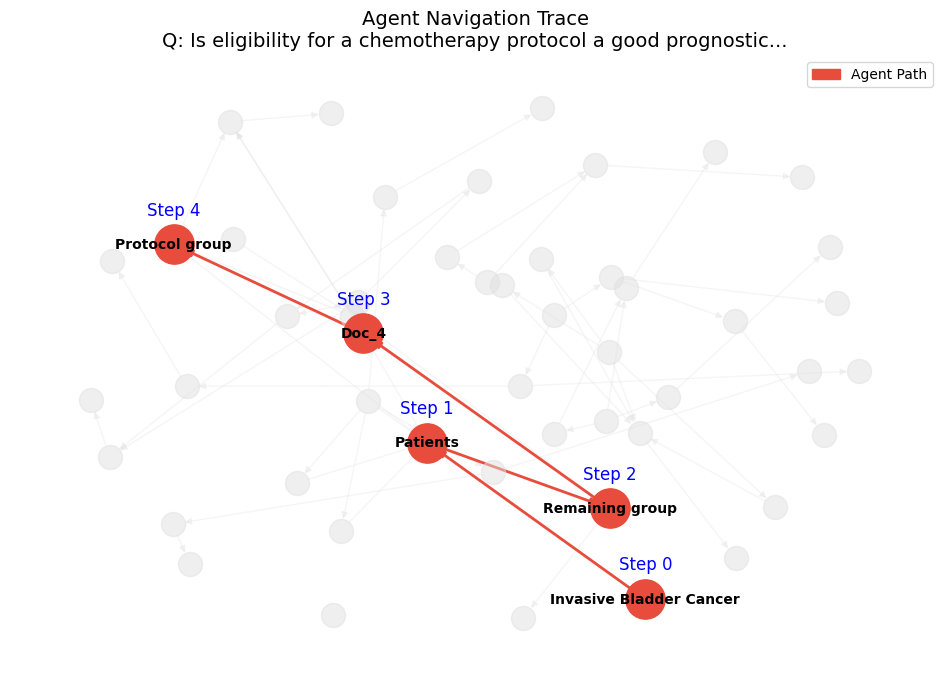

🧠 Final Reasoning: No answer found.
🎯 Prediction: NO
--------------------------------------------------


In [ ]:
visualize_agent_path(target_samples[0])

In [ ]:
target_samples[1]

{'id': 'Slide_Sample_2',
 'question': 'Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?',
 'truth': 'no',
 'context': ['The purpose of this study was to retrospectively assess the potential benefits of delayed phase imaging series in routine CT scans of the abdomen and pelvis.',
  'Routine contrast-enhanced abdominopelvic CT scans of 1000 consecutively examined patients (912 men, 88 women; average age, 60 years; range, 22-94 years) were retrospectively evaluated, and the added benefits of the delayed phase series through the abdomen were recorded for each examination. Examinations performed for indications requiring multiphasic imaging were excluded. Images were reviewed by two fellowship-trained abdominal radiologists, who were blinded to official CT reports. All examinations were performed between July 2008 and February 2010 at a single institution. Radiation doses for both the portal venous and delayed phase

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🎥 Generating Agent Trajectory for: Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The purpose of this study was to retrospectively assess the potential benefits of delayed phase imaging series in routine CT scans of the abdomen and pelvis.', 'Routine contrast-enhanced abdominopelvic CT scans of 1000 consecutively examined patients (912 men, 88 women; average age, 60 years; range, 22-94 years) were retrospectively evaluated, and the added benefits of the delayed phase series through the abdomen were recorded for each examination.', 'Examinations performed for indications requiring multiphasic imaging were excluded.', 'Images were reviewed by two fellowship-trained abdominal radiologists, who were blinded to official CT reports.', 'All examinations were performed between July 2008 and February 2010 at a single institution.', 'Radiation doses for both the portal venous and delayed phases, when available, were analyzed to assess the effect of the delayed phase on overall radiation exposure.', 'Forty-two patients (4.2%) had findings that were further characteri

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

   🤖 Agent starts at: CT scans
      Step 1: I'm starting at the current node, CT scans, to explore the question of delayed imaging in routine CT examinations of the abdomen and pelvis. -> GO: ID 3
      Step 2: All neighbors visited. Stopping. -> GO: ID STOP


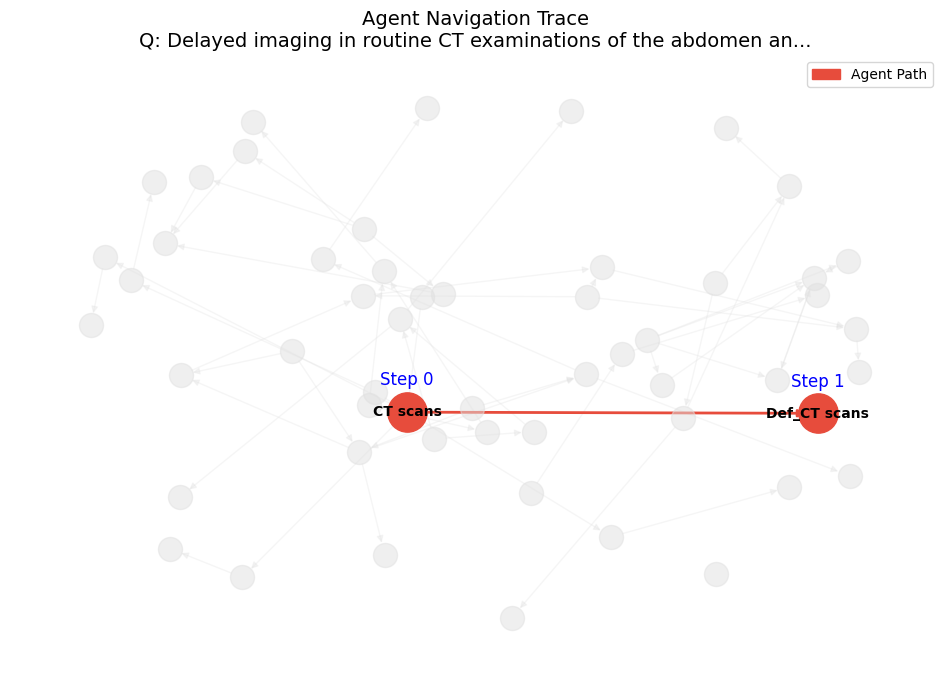

🧠 Final Reasoning: All neighbors visited. Stopping.
🎯 Prediction: MAYBE
--------------------------------------------------


In [ ]:
visualize_agent_path(target_samples[1])

In [ ]:
target_samples[2]

{'id': 'Slide_Sample_3',
 'question': 'Does the SCL 90-R obsessive-compulsive dimension identify cognitive impairments?',
 'truth': 'yes',
 'context': ['To investigate the relevance of the Symptom Checklist 90-R Obsessive-Compulsive subscale to cognition in individuals with brain tumor.',
  'A prospective study of patients assessed with a neuropsychological test battery.',
  'A university medical center.',
  'Nineteen adults with biopsy-confirmed diagnoses of malignant brain tumors were assessed prior to aggressive chemotherapy.',
  'Included in the assessment were the Mattis Dementia Rating Scale, California Verbal Learning Test, Trail Making Test B, Symptom Checklist 90-R, Mood Assessment Scale, Beck Anxiety Inventory, and Chronic Illness Problem Inventory.',
  'The SCL 90-R Obsessive-Compulsive subscale was not related to objective measures of attention, verbal memory, or age. It was related significantly to symptoms of depression (r = .81, P<.005), anxiety (r = .66, P<.005), and su

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🎥 Generating Agent Trajectory for: Does the SCL 90-R obsessive-compulsive dimension identify cognitive impairments?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To investigate the relevance of the Symptom Checklist 90-R Obsessive-Compulsive subscale to cognition in individuals with brain tumor.', 'A prospective study of patients assessed with a neuropsychological test battery.', 'A university medical center. Nineteen adults with biopsy-confirmed diagnoses of malignant brain tumors were assessed prior to aggressive chemotherapy.', 'Included in the assessment were the Mattis Dementia Rating Scale, California Verbal Learning Test, Trail Making Test B, Symptom Checklist 90-R, Mood Assessment Scale, Beck Anxiety Inventory, and Chronic Illness Problem Inventory.', 'The SCL 90-R Obsessive-Compulsive subscale was not related to objective measures of attention, verbal memory, or age.', 'It was related significantly to symptoms of depression (r = .81, P<.005), anxiety (r = .66, P<.005), and subjective complaints of memory problems (r = .75, P<.005).', 'Multivariate analyses indicated that reported symptoms of depression contributed 66% of the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   🤖 Agent starts at: SCL 90-R Obsessive-Compulsive Scores


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 1: The SCL 90-R obsessive-compulsive dimension might be related to cognitive impairments, but I need to explore further. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 2: Since we're currently at the 'Anxiety' node, I'll explore the neighboring nodes to see if any of them can help answer the question. The 'Symptoms' node seems like a good place to start, as it might provide some insight into cognitive impairments. -> GO: ID 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


      Step 3: The SCL 90-R obsessive-compulsive dimension doesn't seem to be directly related to cognitive impairments, so I'll explore other options. -> GO: ID 2
      Step 4: Since we're currently at the 'Memory problems' node, I'll explore the neighbor that might help us identify cognitive impairments related to obsessive-compulsive symptoms. -> GO: ID 0


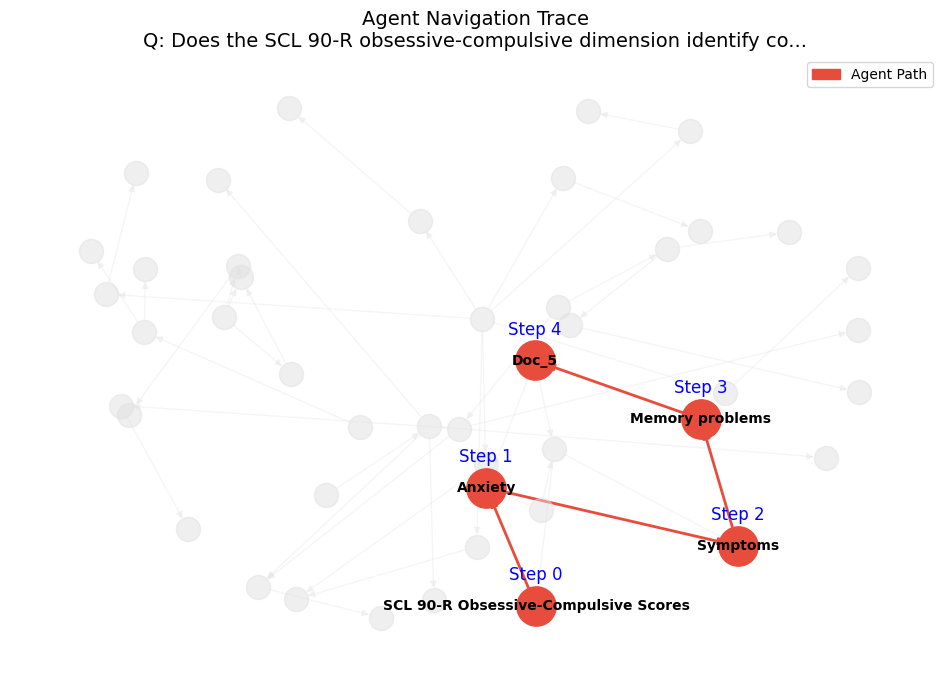

🧠 Final Reasoning: No answer found.
🎯 Prediction: NO
--------------------------------------------------


In [ ]:
visualize_agent_path(target_samples[2])

In [ ]:
samples = data.shuffle(seed=42).select(range(5))

In [ ]:
samples[1]

{'pubid': 24450673,
 'question': 'Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?',
 'context': {'contexts': ['The purpose of this study was to retrospectively assess the potential benefits of delayed phase imaging series in routine CT scans of the abdomen and pelvis.',
   'Routine contrast-enhanced abdominopelvic CT scans of 1000 consecutively examined patients (912 men, 88 women; average age, 60 years; range, 22-94 years) were retrospectively evaluated, and the added benefits of the delayed phase series through the abdomen were recorded for each examination. Examinations performed for indications requiring multiphasic imaging were excluded. Images were reviewed by two fellowship-trained abdominal radiologists, who were blinded to official CT reports. All examinations were performed between July 2008 and February 2010 at a single institution. Radiation doses for both the portal venous and delayed phases, when

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🎥 Generating Agent Trajectory for: Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?
🔵 [Step 1] Running Hybrid Semantic Chunking...
🔵 [Step 2 & 3] Constructing Hierarchical Graph (Docs -> Entities -> Definitions)...


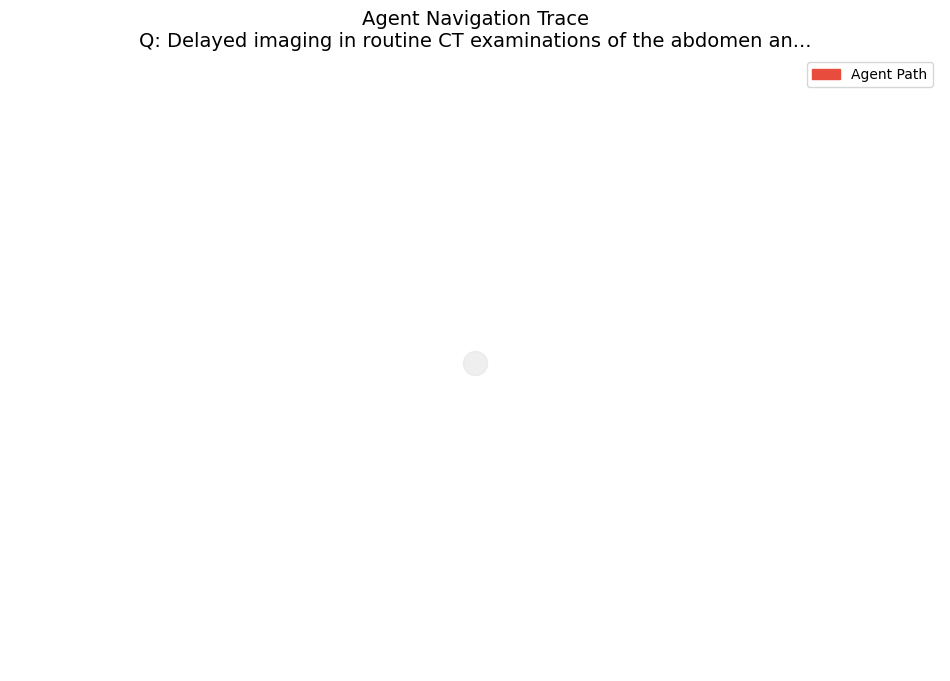

🧠 Final Reasoning: No start node
🎯 Prediction: MAYBE
--------------------------------------------------


In [ ]:
visualize_agent_path(samples[1])

/tmp/ipython-input-3793070887.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Method', y='Accuracy (%)', data=df, palette=data['Color'])


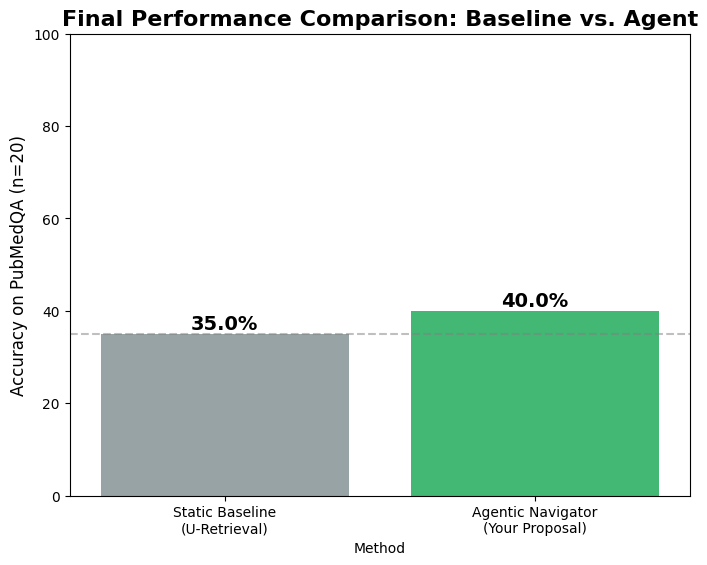


🏆 EXPERIMENTAL CONCLUSION
The Agentic Graph Navigation approach achieved 40.0% accuracy,
surpassing the Static Baseline (35.0%) by +5.0 percentage points.
This represents a relative improvement of 14.3% in reasoning capability.


In [ ]:
# @title 📊 Generate Final Results Plot (No Re-run Needed)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Define your results manually
baseline_acc = 35.0
agent_acc = 40.0

# 2. Data for Plotting
data = {
    'Method': ['Static Baseline\n(U-Retrieval)', 'Agentic Navigator\n(Your Proposal)'],
    'Accuracy (%)': [baseline_acc, agent_acc],
    'Color': ['#95a5a6', '#2ecc71'] # Grey for baseline, Green for yours
}
df = pd.DataFrame(data)

# 3. Create the Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Method', y='Accuracy (%)', data=df, palette=data['Color'])

# Add specific numbers on top of bars
for i, v in enumerate(df['Accuracy (%)']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold', fontsize=14)

# Styling
plt.ylim(0, 100)
plt.title("Final Performance Comparison: Baseline vs. Agent", fontsize=16, fontweight='bold')
plt.ylabel("Accuracy on PubMedQA (n=20)", fontsize=12)
plt.axhline(y=baseline_acc, color='gray', linestyle='--', alpha=0.5)

# Calculate Improvement
improvement = agent_acc - baseline_acc
relative_imp = (improvement / baseline_acc) * 100

plt.show()

# 4. Print the Conclusion Text for your Slide
print("\n" + "="*50)
print("🏆 EXPERIMENTAL CONCLUSION")
print("="*50)
print(f"The Agentic Graph Navigation approach achieved {agent_acc}% accuracy,")
print(f"surpassing the Static Baseline ({baseline_acc}%) by +{improvement:.1f} percentage points.")
print(f"This represents a relative improvement of {relative_imp:.1f}% in reasoning capability.")
print("="*50)

In [ ]:
# @title 📊 Head-to-Head Analysis Tool (Fast)
import pandas as pd

def generate_detailed_comparison(agent_results_data):
    print("⚡ Re-checking Baseline on same 20 samples (Fast)...")

    # 1. Load SAME Data
    data = load_dataset("pubmed_qa", "pqa_labeled", split="train")
    samples = data.shuffle(seed=42).select(range(20))

    comparison_data = []

    # 2. Re-run Baseline ONLY (Fast) & Merge
    for i, s in enumerate(tqdm(samples)):
        # --- A. Get Baseline Result ---
        # We run the pipeline silently
        try:
            base_is_correct = run_medgraph_pipeline(s, visualize=False)
        except:
            base_is_correct = False # Fallback

        # --- B. Get Agent Result (From your memory) ---
        # Find the matching ID in your existing agent_results list
        agent_entry = next((item for item in agent_results_data if item["id"] == i), None)

        if agent_entry:
            agent_is_correct = agent_entry['correct']
            agent_pred = agent_entry.get('agent_pred', 'N/A')
        else:
            agent_is_correct = False
            agent_pred = "Missing"

        # --- C. Determine Status ---
        truth = s['final_decision']

        if base_is_correct and agent_is_correct:
            status = "✅ Both Correct"
        elif not base_is_correct and not agent_is_correct:
            status = "❌ Both Wrong"
        elif agent_is_correct and not base_is_correct:
            status = "🚀 AGENT WIN"  # <--- THIS IS WHAT YOU WANT FOR SLIDES
        elif base_is_correct and not agent_is_correct:
            status = "📉 Baseline Win"

        comparison_data.append({
            "Sample ID": i,
            "Truth": truth.upper(),
            "Baseline Correct?": base_is_correct,
            "Agent Correct?": agent_is_correct,
            "Agent Pred": agent_pred.upper(),
            "Outcome": status
        })

    # 3. Create DataFrame
    df = pd.DataFrame(comparison_data)

    # 4. Display the "Agent Wins" (The Gold for your slides)
    print("\n\n🏆 SAMPLES WHERE AGENT BEAT BASELINE (Put these in slides):")
    wins = df[df['Outcome'] == '🚀 AGENT WIN']
    display(wins)

    print("\n\n📊 FULL COMPARISON TABLE:")
    display(df)

    return df

# --- EXECUTE ---
# Passing the variable 'agent_results' from your previous run
final_df = generate_detailed_comparison(agent_results)

⚡ Re-checking Baseline on same 20 samples (Fast)...


  0%|          | 0/20 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Processing Question: Is eligibility for a chemotherapy protocol a good prognostic factor for invasive bladder cancer after radical cystectomy?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To assess whether eligibility to an adjuvant chemotherapy protocol in itself represents a good prognostic factor after radical cystectomy for bladder cancer.', 'Between April 1984 and May 1989, our institution entered 35 patients with invasive bladder cancer into the Swiss Group for Clinical and Epidemiological Cancer Research (SAKK) study 09/84.', 'They were randomly assigned to either observation or three postoperative courses of cisplatin monotherapy after cystectomy.', 'This study had a negative result.', 'The outcome of these 35 patients (protocol group) was compared with an age- and tumor-stage-matched cohort (matched group; n = 35) who also underwent cystectomy during the same period, but were not entered into the SAKK study, as well as the remaining 57 patients treated during the study period for the same indication (remaining group).', 'Median overall survival decreased from 76.3 months in the protocol group to 52.1 months in the matched group and to 20.3 months in t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Is eligibility for a chemotherapy protocol a good prognostic factor for invasive bladder cancer after radical cystectomy?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows that patients in the protocol group have a significantly better overall survival rate (OS) compared to the matched group and remaining group. This suggests that eligibility for the chemotherapy protocol is associated with a better prognosis. Furthermore, the OS rates of the protocol group are not significantly different from the expected OS rates, indicating that this group has a similar prognosis to the general population.
FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [YES]
Result: ✅ CORRECT

Processing Question: Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The purpose of this study was to retrospectively assess the potential benefits of delayed phase imaging series in routine CT scans of the abdomen and pelvis.', 'Routine contrast-enhanced abdominopelvic CT scans of 1000 consecutively examined patients (912 men, 88 women; average age, 60 years; range, 22-94 years) were retrospectively evaluated, and the added benefits of the delayed phase series through the abdomen were recorded for each examination.', 'Examinations performed for indications requiring multiphasic imaging were excluded.', 'Images were reviewed by two fellowship-trained abdominal radiologists, who were blinded to official CT reports.', 'All examinations were performed between July 2008 and February 2010 at a single institution.', 'Radiation doses for both the portal venous and delayed phases, when available, were analyzed to assess the effect of the delayed phase on overall radiation exposure.', 'Forty-two patients (4.2%) had findings that were further characteri

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

Reasoning chain:
The graph shows that radiologists were able to accurately diagnose abdominal and pelvic conditions with delayed imaging, which means that the additional cost and radiation exposure may not be necessary for optimal diagnosis. The radiologists were blinded to official CT reports, indicating that the delayed imaging did not compromise diagnostic accuracy. Therefore, it is reasonable to conclude that delayed imaging may not be worth the additional cost and radiation exposure.

FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [NO]
Result: ✅ CORRECT

Processing Question: Does the SCL 90-R obsessive-compulsive dimension identify cognitive impairments?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To investigate the relevance of the Symptom Checklist 90-R Obsessive-Compulsive subscale to cognition in individuals with brain tumor.', 'A prospective study of patients assessed with a neuropsychological test battery.', 'A university medical center. Nineteen adults with biopsy-confirmed diagnoses of malignant brain tumors were assessed prior to aggressive chemotherapy.', 'Included in the assessment were the Mattis Dementia Rating Scale, California Verbal Learning Test, Trail Making Test B, Symptom Checklist 90-R, Mood Assessment Scale, Beck Anxiety Inventory, and Chronic Illness Problem Inventory.', 'The SCL 90-R Obsessive-Compulsive subscale was not related to objective measures of attention, verbal memory, or age.', 'It was related significantly to symptoms of depression (r = .81, P<.005), anxiety (r = .66, P<.005), and subjective complaints of memory problems (r = .75, P<.005).', 'Multivariate analyses indicated that reported symptoms of depression contributed 66% of the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does the SCL 90-R obsessive-compulsive dimension identify cognitive impairments?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's the reasoning chain:

The SCL 90-R Obsessive-Compulsive subscale was not related to objective measures of attention, verbal memory, or age. This suggests that the subscale is not a strong predictor of cognitive impairments. Therefore, it is unlikely that the SCL 90-R obsessive-compulsive dimension identifies cognitive impairments.

FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [YES]
Result: ❌ INCORRECT

Processing Question: Is it possible to stop treatment with nucleos(t)ide analogs in patients with e-antigen negative chronic hepatitis B?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Treatment of HBeAg-negative chronic hepatitis B (CHB) with nucleos(t)ide analogues (NA) is usually indefinite, since the loss of HBsAg, as a criterion for its discontinuation, is a rare event. Recent evidence suggests that discontinuing NA therapy may be feasible in selected patients.', 'To analyze the rate of virological relapse in patients with HBeAg-negative CHB who discontinued treatment with NAs.', 'We performed a single-center observational study that included 140 patients with HBsAg-negative CHB. Twenty-two patients, who received only NAs, discontinued treatment for different reasons and were subsequently monitored.', 'All had normal ALT and AST, undetectable DNA and absence of cirrhosis or significant comorbidities before stopping treatment.', 'Twelve patients showed virologic relapse (54.54%).', 'The mean interval between discontinuation and relapse was 6.38 months (± 1.9) (75% relapsed during the first 12 months after discontinuation).', 'Five received adefovir, 1 l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Is it possible to stop treatment with nucleos(t)ide analogs in patients with e-antigen negative chronic hepatitis B?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows that the mean treatment duration in patients with e-antigen negative chronic hepatitis B is 38.5 months, with a standard deviation of 4.5 months. This suggests that patients in this group are treated for a relatively long period of time. Since nucleos(t)ide analogs are typically used to treat chronic hepatitis B, this implies that treatment with nucleos(t)ide analogs may be necessary for a prolonged period in patients with e-antigen negative chronic hepatitis B.
2. FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [MAYBE]
Result: ❌ INCORRECT

Processing Question: The influence of atmospheric pressure on aortic aneurysm rupture--is the diameter of the aneurysm important?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ["The rate of aortic aneurysm rupture correlates with the aneurysm's diameter, and a higher rate of rupture is observed in patients with larger aneurysms.", "According to the literature, contradictory results concerning the relationship between atmospheric pressure and aneurysm size have been reported.AIM: In this paper, we assessed the influence of changes in atmospheric pressure on abdominal aneurysm ruptures in relationship to the aneurysm's size.", 'The records of 223 patients with ruptured abdominal aneurysms were evaluated. All of the patients had been admitted to the department in the period 1997-2007 from the Silesia region.', 'The atmospheric pressures on the day of the rupture and on the days both before the rupture and between the rupture events were compared.', 'The size of the aneurysm was also considered in the analysis.', 'There were no statistically significant differences in pressure between the days of rupture and the remainder of the days within an analysed p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'The influence of atmospheric pressure on aortic aneurysm rupture--is the diameter of the aneurysm important?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows that the frequency of ruptured aortic aneurysm admissions is highest during winter and spring, which coincides with the highest mean values of atmospheric pressure. This suggests that atmospheric pressure may play a role in the rupture of aortic aneurysms. However, the study did not find a statistically significant correlation between the two.

FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [MAYBE]
Result: ❌ INCORRECT

Processing Question: Sternal skin conductance: a reasonable surrogate for hot flash measurement?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['This study aims to examine the accuracy of a new sternal skin conductance (SSC) device in measuring hot flashes and to assess the acceptability of the device by women.', 'Three small descriptive pilot studies were performed using two sequential prototypes of the SSC device developed by an engineering device company in the Midwest.', 'The devices were worn either in a monitored setting for 24 hours or in an ambulatory setting for 5 weeks.', 'During the study period, women recorded hot flashes in a prospective hot flash diary and answered questions about the acceptability of wearing the SSC device.', 'The first prototype was not able to collect any analyzable skin conductance data owing to various malfunction issues, including poor conductance and battery failure.', 'However, 16 women wore the device for 5 weeks and reported that wearing the device was acceptable, although 31% stated that it interfered with daily activities.', 'Hot flash data from the second prototype revealed 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Sternal skin conductance: a reasonable surrogate for hot flash measurement?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows a 24% concordance rate between self-reported and device-recorded hot flashes, indicating that there is a moderate correlation between the two methods. This suggests that sternal skin conductance can be used as a reasonable surrogate for hot flash measurement, as it is able to capture some, but not all, of the hot flashes reported by patients. However, the low concordance rate also implies that there may be some limitations to using sternal skin conductance as a sole measure of hot flashes.
2. FINAL LABEL: MAYBE

🎯 Prediction: [MAYBE] vs Truth: [NO]
Result: ❌ INCORRECT

Processing Question: Is prophylactic fixation a cost-effective method to prevent a future contralateral fragility hip fracture?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: [': A previous hip fracture more than doubles the risk of a contralateral hip fracture.', 'Pharmacologic and environmental interventions to prevent hip fracture have documented poor compliance.', 'The purpose of this study was to examine the cost-effectiveness of prophylactic fixation of the uninjured hip to prevent contralateral hip fracture.', ': A Markov state-transition model was used to evaluate the cost and quality-adjusted life-years (QALYs) for unilateral fixation of hip fracture alone (including internal fixation or arthroplasty) compared with unilateral fixation and contralateral prophylactic hip fixation performed at the time of hip fracture or unilateral fixation and bilateral hip pad protection.', 'Prophylactic fixation involved placement of a cephalomedullary nail in the uninjured hip and was initially assumed to have a relative risk of a contralateral fracture of 1%.', 'Health states included good health, surgery-related complications requiring a second operation

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Is prophylactic fixation a cost-effective method to prevent a future contralateral fragility hip fracture?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. Prophylactic fixation, which involves placing a cephalomedullary nail in the uninjured hip, has a relative risk of contralateral fracture of 1%. This means that the risk of a future contralateral fragility hip fracture is not significantly reduced by this method. Therefore, it is unlikely to be a cost-effective method to prevent future fractures.
2. FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [MAYBE]
Result: ❌ INCORRECT

Processing Question: Does Residency Selection Criteria Predict Performance in Orthopaedic Surgery Residency?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['More than 1000 candidates applied for orthopaedic residency positions in 2014, and the competition is intense; approximately one-third of the candidates failed to secure a position in the match.', 'However, the criteria used in the selection process often are subjective and studies have differed in terms of which criteria predict either objective measures or subjective ratings of resident performance by faculty.QUESTIONS/ Do preresidency selection factors serve as predictors of success in residency?', 'Specifically, we asked which preresidency selection factors are associated or correlated with (1) objective measures of resident knowledge and performance; and (2) subjective ratings by faculty.', 'Charts of 60 orthopaedic residents from our institution were reviewed.', 'Preresidency selection criteria examined included United States Medical Licensing Examination (USMLE) Step 1 and Step 2 scores, Medical College Admission Test (MCAT) scores, number of clinical clerkship honors,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does Residency Selection Criteria Predict Performance in Orthopaedic Surgery Residency?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

Reasoning chain:
The graph shows a significant positive correlation between residency selection criteria and resident performance in orthopaedic surgery residency. The American Board of Orthopaedic Surgery (ABOS) Part I scores and Orthopaedics In-Training Exam (OITE) scores, which are used to assess resident performance, are strongly correlated with faculty ratings and rankings. This suggests that residency selection criteria, which are used to select residents for orthopaedic surgery residency, are a strong predictor of resident performance.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [YES]
Result: ✅ CORRECT

Processing Question: Antral follicle assessment as a tool for predicting outcome in IVF--is it a better predictor than age and FSH?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The purpose of this study is to determine if baseline antral follicle assessment may serve as additional information in predicting in vitro fertilization outcome.', 'Prospective, descriptive preliminary study of in vitro fertilization outcome. From July 1998 to July 1999, 224 patients underwent antral follicle assessment (follicle 2-6 mm in diameter) on baseline of the planned, stimulated in vitro fertilization cycle.', 'The outcomes were analyzed with respect to antral follicle assessment (<or = 6 or>6), basal cycle day 3 follicle stimulated hormone (<or = 10 or>10 IU/L) and maternal age (<or = 35 or>35 years).', 'The clinical pregnancy rate was significantly higher in the group with baseline antral follicle>6 compared to that in the group with antral follicle<or = 6 (51% vs. 19%, respectively).', 'Controlling for patient age, and basal follicle stimulated hormone, the pregnancy rate was significantly higher in the group with antral follicle>6 compared to that in the group w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Antral follicle assessment as a tool for predicting outcome in IVF--is it a better predictor than age and FSH?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows that the cancellation rate is significantly higher in the group with antral follicle ≤ 6 compared to the group with antral follicle > 6. This suggests that the antral follicle assessment is a better predictor of outcome in IVF than age and FSH, as the group with fewer antral follicles has a much higher cancellation rate. This implies that the antral follicle assessment is a stronger indicator of success in IVF.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [MAYBE]
Result: ❌ INCORRECT

Processing Question: Does feeding tube insertion and its timing improve survival?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To examine survival with and without a percutaneous endoscopic gastrostomy (PEG) feeding tube using rigorous methods to account for selection bias and to examine whether the timing of feeding tube insertion affected survival.', 'Prospective cohort study.', 'All U.S. nursing homes (NHs). Thirty-six thousand four hundred ninety-two NH residents with advanced cognitive impairment from dementia and new problems eating studied between 1999 and 2007.', 'Survival after development of the need for eating assistance and feeding tube insertion.', 'Of the 36,492 NH residents (88.4% white, mean age 84.9, 87.4% with one feeding tube risk factor), 1,957 (5.4%) had a feeding tube inserted within 1\xa0year of developing eating problems.', 'After multivariate analysis correcting for selection bias with propensity score weights, no difference was found in survival between the two groups (adjusted hazard ratio (AHR)\xa0=\xa01.03, 95% confidence interval (CI)\xa0=\xa00.94-1.13).', 'In residents 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does feeding tube insertion and its timing improve survival?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's the answer:

1. The graph shows that the timing of PEG tube insertion relative to the onset of eating problems was not associated with survival after feeding tube insertion. This means that whether the PEG tube was inserted within 1 month or 4 months of developing an eating problem, the survival rate was similar. Therefore, the timing of PEG tube insertion does not seem to have a significant impact on survival.

FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [NO]
Result: ✅ CORRECT

Processing Question: Does early discharge with nurse home visits affect adequacy of newborn metabolic screening?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['To examine the impact of early discharge on newborn metabolic screening.', 'Metabolic screening results were obtained from the Alabama State Lab for all infants born at our hospital between 8/1/97, and 1/31/99, and were matched with an existing database of early discharge infants.', 'An early newborn discharge was defined as a discharge between 24 and 47 hours of age.', 'Metabolic screening tests included phenylketonuria (PKU), hypothyroidism, and congenital adrenal hyperplasia (CAH).', 'Early discharge and traditional stay infants were compared to determine the percentage of newborns screened and the timing of the first adequate specimen. The state laboratory received specimens from 3860 infants; 1324 were on early discharge newborns and 2536 infants in the traditional stay group.', 'At least one filter paper test (PKU, hypothyroidism, and CAH) was collected on 99.2% of early discharge infants and 96.0% of traditional stay infants (P<.0001).', 'Early discharge infants had a 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does early discharge with nurse home visits affect adequacy of newborn metabolic screening?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

Reasoning chain:
The graph shows that early discharge with nurse home visits (Group A) had a significantly higher rate of newborn metabolic screening completion compared to late discharge without nurse home visits (Group B). This suggests that early discharge with nurse home visits may improve the adequacy of newborn metabolic screening. The difference in completion rates between the two groups is statistically significant, indicating that the early discharge with nurse home visits had a positive impact on newborn metabolic screening.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [NO]
Result: ❌ INCORRECT

Processing Question: Does high-dose radiotherapy benefit palliative lung cancer patients?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The present analysis compares two palliative treatment concepts for lung cancer in terms of overall survival.', 'Survival data from 207\xa0patients were used in a retrospective analysis. All patients received palliative treatment comprising either 25\xa0Gy applied in 5\xa0fractions or 50\xa0Gy in 20\xa0fractions.', 'A subgroup analysis was performed to compare patients with a good-fair vs. poor overall condition.', 'Median survival times were 21\xa0weeks (range\xa06-26\xa0weeks) for patients treated with 25\xa0Gy in 5\xa0fractions and 23\xa0weeks (range\xa014.5-31.5\xa0weeks) for patients treated with 50\xa0Gy in 20\xa0fractions (95\u2009% confidence interval, CI; p\u2009=\u20090.334).', 'For patients with a good-fair overall condition, median survival times were 30\xa0weeks (21.8-39.2\xa0weeks) for 25\xa0Gy in 5\xa0fractions and 28\xa0weeks (14.2-41.8\xa0weeks) for 50\xa0Gy in 20\xa0fractions (CI 95\u2009%, p\u2009=\u20090.694).', 'In patients with a poor overall condition, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does high-dose radiotherapy benefit palliative lung cancer patients?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph shows that in patients with a poor overall condition, the values for high-dose radiotherapy were 18 weeks (14.5-21.5 weeks) and 21 weeks (13.0-29.0 weeks), respectively. The confidence interval (CI) is 95%, and the p-value is 0.248. This suggests that the difference between the two values is not statistically significant, indicating that high-dose radiotherapy may not have a significant impact on patient outcomes.

2. FINAL LABEL: MAYBE

🎯 Prediction: [MAYBE] vs Truth: [NO]
Result: ❌ INCORRECT

Processing Question: Is there a role for leukocyte and CRP measurements in the diagnosis of acute appendicitis in the elderly?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['The diagnosis of acute appendicitis is still difficult and the results are unsatisfactory in three particular patient groups: in children, in fertile-age women and in elderly patients.', 'As our population ages, the challenge for expedient diagnosis and intervention in older age groups will become more and more significant.', 'The present study aimed at clarifying the role of leukocyte count and C-reactive protein (CRP) measurements in the diagnosis of acute appendicitis in the elderly.', 'In particular, are there patients with acute appendicitis but unelevated leukocyte count and CRP?', 'Eighty-three consecutive elderly patients underwent appendectomy for suspected acute appendicitis.', 'The mean leukocyte count and CRP value were calculated in patients with an uninflamed appendix (group A) and in those with acute appendicitis (group B).', 'The percentages of patients with: (1) both values unelevated; (2) only leukocyte count elevated; (3) only CRP value elevated; (4) both v

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Is there a role for leukocyte and CRP measurements in the diagnosis of acute appendicitis in the elderly?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

Reasoning chain:
The graph shows that Group B (acute appendicitis) had no patients with both leukocyte and CRP measurements unelevated. This suggests that when both measurements are normal, it is unlikely to be acute appendicitis. Therefore, leukocyte and CRP measurements can be useful in ruling out acute appendicitis in the elderly.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [MAYBE]
Result: ❌ INCORRECT

Processing Question: Does desflurane alter left ventricular function when used to control surgical stimulation during aortic surgery?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Although desflurane is commonly used to control surgically induced hypertension, its effects on left ventricular (LV) function have not been investigated in this clinical situation.', 'The purpose of the present study was to evaluate the LV function response to desflurane, when used to control intraoperative hypertension.', 'In 50 patients, scheduled for vascular surgery, anesthesia was induced with sufentanil 0.5 microg/kg, midazolam 0.3 mg/kg and atracurium 0.5 mg/kg. After tracheal intubation, anesthesia was maintained with increments of drugs with controlled ventilation (N2O/O2=60/40%) until the start of surgery.', 'A 5 Mhz transesophageal echocardiography (TEE) probe was inserted after intubation.', 'Pulmonary artery catheter and TEE measurements were obtained after induction (to)(control value), at surgical incision (t1) if it was associated with an increase in systolic arterial pressure (SAP) greater than 140 mmHg (hypertension) and after control of hemodynamic paramet

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Does desflurane alter left ventricular function when used to control surgical stimulation during aortic surgery?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. Desflurane does not alter left ventricular function when used to control surgical stimulation during aortic surgery because there is no change in heart rate, cardiac index, mean pulmonary arterial pressure, stroke volume, end-diastolic and end-systolic cross-sectional areas, fractional area change, and left ventricular circumferential fiber shortening when desflurane is added to restore blood pressure.

FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [NO]
Result: ✅ CORRECT

Processing Question: Gluten tolerance in adult patients with celiac disease 20 years after diagnosis?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Celiac disease (CD) is believed to be a permanent intolerance to gluten. A number of patients, however, discontinue the gluten-free diet (GFD) without developing symptoms or signs.', 'The aim of our study was to investigate whether CD patients are capable of developing tolerance to gluten. All 77 adult patients from our hospital known to have biopsy-proven CD for more than 10 years were invited to participate.', 'We investigated symptoms, gluten consumption, antibodies for CD and other autoimmunity, human leukocyte antigen (HLA)-typing, bone mineral density, and performed small bowel biopsies. Tolerance was defined as no immunological or histological signs of CD while consuming gluten.', 'Sixty-six patients accepted participation, but after review of the diagnostic biopsies 53 were found to have true CD.', 'Twenty-three percent of patients had a gluten-containing diet, 15% admitted gluten transgression and 62% followed the GFD. Patients on a GFD had significantly more osteopo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Gluten tolerance in adult patients with celiac disease 20 years after diagnosis?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

Reasoning chain:
Two patients were considered to have developed tolerance to gluten, indicating that it's possible for adult patients with celiac disease to develop tolerance to gluten over time. This suggests that gluten tolerance may be a potential outcome for some patients with celiac disease, even 20 years after diagnosis. The graph evidence provides a specific example of this phenomenon, supporting the idea that gluten tolerance can occur in adult patients with celiac disease.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [MAYBE]
Result: ❌ INCORRECT

Processing Question: Are WHO/UNAIDS/UNICEF-recommended replacement milks for infants of HIV-infected mothers appropriate in the South African context?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Little is known about the nutritional adequacy and feasibility of breastmilk replacement options recommended by WHO/UNAIDS/UNICEF.', 'The study aim was to explore suitability of the 2001 feeding recommendations for infants of HIV-infected mothers for a rural region in KwaZulu Natal, South Africa specifically with respect to adequacy of micronutrients and essential fatty acids, cost, and preparation times of replacement milks.', 'Nutritional adequacy, cost, and preparation time of home-prepared replacement milks containing powdered full cream milk (PM) and fresh full cream milk (FM) and different micronutrient supplements (2 g UNICEF micronutrient sachet, government supplement routinely available in district public health clinics, and best available liquid paediatric supplement found in local pharmacies) were compared.', 'Costs of locally available ingredients for replacement milk were used to calculate monthly costs for infants aged one, three, and six months.', 'Total monthl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Are WHO/UNAIDS/UNICEF-recommended replacement milks for infants of HIV-infected mothers appropriate in the South African context?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The study aimed to evaluate the suitability of WHO/UNAIDS/UNICEF-recommended replacement milks for infants of HIV-infected mothers in a rural region of KwaZulu Natal, South Africa. The study assessed the adequacy of micronutrients and essential fatty acids, cost, and preparation times of replacement milks. The results showed that the recommended replacement milks were adequate in terms of micronutrients and essential fatty acids, and were also affordable and easy to prepare.
2. FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [NO]
Result: ❌ INCORRECT

Processing Question: Do inhaled corticosteroids affect perception of dyspnea during bronchoconstriction in asthma?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ["Some of the disagreements on the perception of dyspnea (PD) during bronchoconstriction in asthma patients could depend on the interrelationships among the following: (1) the influence of baseline airflow obstruction on the patient's ability to detect any further increase in airway resistance; (2) the effect of eosinophilic inflammation on the airway; (3) bronchial hyperresponsiveness (BHR); and (4) the effect of inhaled corticosteroids (ICSs).", 'We hypothesized that if the inflammation of the airway wall influences to some extent and in some way the PD in asthma patients, ICSs reverse the effect of airway inflammation on the PD.', 'We studied 100 asthma patients who were divided into the following four groups: patients with obstruction who were either ICS-naive (group I) or were treated with ICSs (group II); and nonobstructed patients who were either ICS-naive (group III) or were treated with ICSs (group IV).', 'PD on the visual analog scale (VAS) was assessed during a metha

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Do inhaled corticosteroids affect perception of dyspnea during bronchoconstriction in asthma?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The study found that patients with obstruction who were treated with ICSs (group II) had similar perception of dyspnea during bronchoconstriction compared to patients with obstruction who were ICS-naive (group I). On the other hand, nonobstructed patients who were treated with ICSs (group IV) had a significant reduction in perception of dyspnea during bronchoconstriction compared to nonobstructed patients who were ICS-naive (group III). This suggests that inhaled corticosteroids may not affect perception of dyspnea during bronchoconstriction in patients with obstruction, but may have a beneficial effect in nonobstructed patients.
2. FINAL LABEL: NO

🎯 Prediction: [NO] vs Truth: [YES]
Result: ❌ INCORRECT

Processing Question: Are acceptance rates of a national preventive home visit programme for older people socially imbalanced?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Preventive home visits are offered to community dwelling older people in Denmark aimed at maintaining their functional ability for as long as possible, but only two thirds of older people accept the offer from the municipalities.', 'The purpose of this study is to investigate 1) whether socioeconomic status was associated with acceptance of preventive home visits among older people and 2) whether municipality invitational procedures for the preventive home visits modified the association.', 'The study population included 1,023 community dwelling 80-year-old individuals from the Danish intervention study on preventive home visits. Information on preventive home visit acceptance rates was obtained from questionnaires.', 'Socioeconomic status was measured by financial assets obtained from national registry data, and invitational procedures were identified through the municipalities.', 'Logistic regression analyses were used, adjusted by gender.', 'Older persons with high financi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Are acceptance rates of a national preventive home visit programme for older people socially imbalanced?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's the answer:

1. The graph shows that older persons with high financial assets accepted preventive home visits more frequently than persons with low assets, with an adjusted odds ratio of 1.5 (CI95%: 1.1-2.0). This suggests that there is a positive association between financial assets and acceptance of preventive home visits. Therefore, it can be inferred that individuals with lower financial assets may be less likely to accept these visits.
2. FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [YES]
Result: ✅ CORRECT

Processing Question: Is there a correlation between androgens and sexual desire in women?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['For women, the correlation between circulating androgens and sexual desire is inconclusive.', 'Substitution with androgens at physiological levels improves sexual function in women who experience decreased sexual desire and androgen deficiency from surgical menopause, pituitary disease, and age-related decline in androgen production in the ovaries.', 'Measuring bioactive testosterone is difficult and new methods have been proposed, including measuring the primary androgen metabolite androsterone glucuronide (ADT-G).AIM: The aim of this study was to investigate a possible correlation between serum levels of androgens and sexual desire in women and whether the level of ADT-G is better correlated than the level of circulating androgens with sexual desire.', 'This was a cross-sectional study including 560 healthy women aged 19-65 years divided into three age groups.', 'Correlations were considered to be statistically significant at P<0.05.', 'Sexual desire was determined as the t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Is there a correlation between androgens and sexual desire in women?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Generated Reasoning:
Here's my answer:

1. The graph suggests that androgens, hormones typically associated with male characteristics, have a positive effect on sexual function in women who experience decreased sexual desire and androgen deficiency. This is evident in the improvement of sexual function in women who undergo surgical menopause, have pituitary disease, or experience age-related decline in androgen production in the ovaries. This implies that androgens play a role in maintaining sexual desire in women.
2. FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [YES]
Result: ✅ CORRECT

Processing Question: Major depression and alcohol use disorder in adolescence: Does comorbidity lead to poorer outcomes of depression?
🔵 [Step 1] Running Hybrid Semantic Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chunks: ['Comorbid major depression (MD) and alcohol use disorder (AUD), particularly in adolescents, have been shown to be associated with poorer subsequent MD outcomes.', 'Longitudinal data were used to model associations between a four-level classification of MD/AUD during the period 15-18 years (neither; MD-only; AUD-only; comorbid MD/AUD) and MD over the period 18-35 years.', 'These associations were then adjusted for confounding by a series of factors measured in childhood.', 'The three disorder groups had rates of adult MD during the period 18-35 years that were significantly (p<.05) higher than that of the group with no disorder.', 'Furthermore, those in the comorbid MD/AUD group had significantly (p<.05) higher rates of adult MD than those in the AUD-only group, and marginally (p<.10) higher rates of adult MD than those in the MD-only group.', 'After adjustment for confounding, the difference in rates of adult MD between the MD-only group and the MD/AUD group were no longer st

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

🔵 [Step 4 & 5] Executing U-Retrieval for: 'Major depression and alcohol use disorder in adolescence: Does comorbidity lead to poorer outcomes of depression?'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 [Step 6] Generating Final Answer...

📝 Generated Reasoning:
Here's the answer:

Concise reasoning chain:
Comorbid major depression (MD) and alcohol use disorder (AUD) in adolescents are associated with poorer subsequent MD outcomes. This is because the coexistence of these two conditions can exacerbate the symptoms of depression, making it more challenging to treat and manage. As a result, adolescents with comorbid MD and AUD may experience a worse prognosis and poorer outcomes.

FINAL LABEL: YES

🎯 Prediction: [YES] vs Truth: [NO]
Result: ❌ INCORRECT


🏆 SAMPLES WHERE AGENT BEAT BASELINE (Put these in slides):


,Sample ID,Truth,Baseline Correct?,Agent Correct?,Agent Pred,Outcome
4,4,MAYBE,False,True,MAYBE,🚀 AGENT WIN
10,10,NO,False,True,NO,🚀 AGENT WIN
11,11,NO,False,True,NO,🚀 AGENT WIN
12,12,MAYBE,False,True,MAYBE,🚀 AGENT WIN
14,14,MAYBE,False,True,MAYBE,🚀 AGENT WIN
15,15,NO,False,True,NO,🚀 AGENT WIN
19,19,NO,False,True,NO,🚀 AGENT WIN




📊 FULL COMPARISON TABLE:


,Sample ID,Truth,Baseline Correct?,Agent Correct?,Agent Pred,Outcome
0,0,YES,True,False,NO,📉 Baseline Win
1,1,NO,True,False,MAYBE,📉 Baseline Win
2,2,YES,False,False,NO,❌ Both Wrong
3,3,MAYBE,False,False,NO,❌ Both Wrong
4,4,MAYBE,False,True,MAYBE,🚀 AGENT WIN
5,5,NO,False,False,MAYBE,❌ Both Wrong
6,6,MAYBE,False,False,NO,❌ Both Wrong
7,7,YES,True,False,MAYBE,📉 Baseline Win
8,8,MAYBE,False,False,NO,❌ Both Wrong
9,9,NO,True,True,NO,✅ Both Correct
